In [ ]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
from scipy.stats import median_abs_deviation as mad_estimate
from natsort import natsorted

In [ ]:
def filter_changepoints(
    changepoints,
    chromosome_start,
    tollerance = 20
    ):
    changepoints = np.array(changepoints)
    chromosome_start = np.array(chromosome_start)

    # Create a mask where True means the changepoint should be kept
    mask = np.ones_like(changepoints, dtype=bool)

    for cs in chromosome_start:
        mask &= ~((changepoints >= cs - tollerance) & (changepoints <= cs + tollerance))

    return changepoints[mask]

In [ ]:
def calculate_preformance(
    true_changepoint,
    pred_changepoint
    ):
    both_non_empty = 0
    first_empty_second_non_empty = 0
    first_non_empty_second_empty = 0
    both_empty = 0

    # Ensure both dictionaries have the same keys
    keys = set(true_changepoint.keys()).intersection(pred_changepoint.keys())

    for key in keys:
        len1 = len(true_changepoint[key])
        len2 = len(pred_changepoint[key])

        if len1 > 0 and len2 > 0:
            both_non_empty += 1
        elif len1 == 0 and len2 > 0:
            first_empty_second_non_empty += 1
        elif len1 > 0 and len2 == 0:
            first_non_empty_second_empty += 1
        else:  # len1 == 0 and len2 == 0
            both_empty += 1

    return {
        "TP": both_non_empty,
        "FP": first_empty_second_non_empty,
        "FN": first_non_empty_second_empty,
        "TN": both_empty
    }

In [ ]:
def plot_genome_logratios(
    data,
    changepoints=[],
    chromosome=[]
):
    plt.figure(figsize=(20, 4))  # pick any size you like
    plt.scatter(range(len(data)), data, s=2)
    plt.xlabel('Genomic Position')
    plt.ylabel('Log Ratio')
    plt.title('Genome-wide Log Ratios')

    # Plot changepoints
    for cp in changepoints:
        plt.axvline(x=cp, color='r', linestyle='--', alpha=0.5, label='Changepoint' if cp == changepoints[0] else "")

    # Plot chromosome ends
    for cs in chromosome:
        plt.axvline(x=cs, color='k', linestyle='-', alpha=0.7, label='Chromosome End' if cs == chromosome[0] else "")

    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
from abc import ABC, abstractmethod

################################################################################
# 1) Abstract base class for Cost Functions
################################################################################

class CostFunction(ABC):
    """
    Abstract base class: any cost function used by OptimalPartitioning
    must implement these methods.
    """

    @abstractmethod
    def precompute_summaries(self, data: np.ndarray, weights: np.ndarray = None):
        """
        Perform one-time computations (e.g. cumsums) needed to quickly
        evaluate segment costs. Some cost functions may also handle 'weights'.
        """
        pass

    @abstractmethod
    def cost(self, start: int, end: int) -> float:
        """
        Returns the cost (negative log-likelihood or sum of squares, etc.)
        for the segment data[start:end+1].
        Indices are inclusive, 0-based.
        """
        pass

################################################################################
# 2) Concrete cost classes
################################################################################

class GaussianCPInMeanCost(CostFunction):
    """
    Example for a Weighted Gaussian change-in-mean model:
      cost(segment) = sum( w_i * (y_i - mu)^2 ).
    We store cumsum(w), cumsum(w*y), cumsum(w*y^2).
    """

    def __init__(self):
        self.cum_w     = None
        self.cum_wy    = None

    def precompute_summaries(self, data: np.ndarray, weights: np.ndarray = None):
        if weights is None:
            # default to all weights = 1
            weights = np.ones_like(data)

        n = len(data)

        self.cum_w  = np.concatenate(([0], np.cumsum(weights)))
        self.cum_wy = np.concatenate(([0], np.cumsum(weights*data)))

    def cost(self, start: int, end: int) -> float:
        w_seg  = self.cum_w[end]   - self.cum_w[start]
        wy_seg = self.cum_wy[end]  - self.cum_wy[start]

        return - (wy_seg**2)/w_seg

################################################################################
# 3) The OptimalPartitioning class with min seg length
################################################################################

class OptimalPartitioning:
    """
    Generic implementation of the Optimal Partitioning (OP) algorithm, with:
      - penalty (beta)
      - any cost function implementing CostFunction
      - minimum segment length
    """

    def __init__(self,
                 penalty: float,
                 cost_func: CostFunction,
                 min_seg_len: int = 1):
        """
        Parameters
        ----------
        penalty : float
            The penalty (beta) for each new segment.
        cost_func : CostFunction
            An instance implementing cost() and precompute_summaries().
        min_seg_len : int
            The minimum allowable segment length.
        """
        self.penalty         = penalty
        self.cost_func       = cost_func
        self.min_seg_len     = min_seg_len

        # Will be filled after calling .fit():
        self._L   = None
        self._cp  = None
        self.n    = 0
        self.data = None
        self.changepoints = None   # final result

    def fit(self, data: np.ndarray, weights: np.ndarray = None):
        """
        Run the dynamic programming recursion.
        data: the 1D time series.
        weights: optional array of same shape as data (for Weighted cost).
        """
        self.data = data
        self.n    = len(data)

        # 1) Precompute cost function summaries
        self.cost_func.precompute_summaries(data, weights)

        # 2) Initialize DP arrays
        L    = np.full(self.n+1, np.inf, dtype=float)
        cp   = np.zeros(self.n+1, dtype=int)
        L[0] = -self.penalty  # so that for t=1, it cancels out

        # 3) Main recursion
        for t in range(1, self.n+1):
            best_val = np.inf
            best_tau = 0

            for tau in range(0, t - self.min_seg_len + 1):
                val = L[tau] + self.cost_func.cost(tau, t) + self.penalty
                if val < best_val:
                    best_val = val
                    best_tau = tau

            L[t]  = best_val
            cp[t] = best_tau

        # 4) Save DP arrays
        self._L  = L
        self._cp = cp

        # 5) Backtrack to get changepoints
        changepoints = []
        curr = self.n
        while curr > 0:
            tau_star = cp[curr]
            # record the boundary (if > 0)
            if tau_star > 0:
                changepoints.append(tau_star)
            curr = tau_star
        changepoints.reverse()
        self.changepoints = changepoints

    def get_changepoints(self):
        return self.changepoints

    def get_min_cost(self):
        """
        The minimal cost of segmenting the entire dataset (index 0..n-1).
        """
        return self._L[-1] if self._L is not None else None

### LogRatioExtractor Class
The `LogRatioExtractor` class is designed to process a pandas DataFrame containing genomic log-ratio data and extract log-ratio arrays grouped by specific criteria. It provides flexibility in handling anomalies, annotations, and grouping by chromosomes or profiles.

#### **Initialization (`__init__` method)**
- **`df` (DataFrame):** Input data with columns like `['profile.id', 'chromosome', 'position', 'logratio', 'annotation', 'anomaly']`.
- **`profile` (bool):** If `True`, groups by `profile.id`; if `False`, groups by both `profile.id` and `chromosome`.
- **`drop_anomaly` (bool):** If `True`, removes rows where `anomaly == 1`.
- **`annotation` (str or list[str]):** Filters rows based on specified annotation(s).

#### **Log-Ratio Extraction (`get_logratio_dict` method)**
- **Anomaly Filtering:** Optionally removes rows marked as anomalies.
- **Annotation Filtering:** Keeps rows that match the specified annotation(s).
- **Grouping:** Data is grouped by:
  - Both `profile.id` and `chromosome` if `profile=False`.
  - Only `profile.id` if `profile=True`.
- **Outputs:**
  - **`logratio_dict:`** A dictionary mapping group keys to NumPy arrays of log-ratios.
  - **`annotation_dict:`** A dictionary mapping group keys to annotations.
  - **`start_chromosome:`** (Only if `profile=True`) Cumulative counts of logratios per chromosome.

#### **Return Values**
- If `profile=True`: Returns `logratio_dict`, `annotation_dict`, and `start_chromosome`.
- If `profile=False`: Returns `logratio_dict` and `annotation_dict`.

This class is useful for extracting and organizing log-ratio data from genomic datasets for further analysis.



In [ ]:
class LogRatioExtractor:
    def __init__(self, df, profile=True, drop_anomaly=True, annotation=None):
        """
        df : pandas DataFrame containing columns:
             ['profile.id','chromosome','position','logratio','annotation','anomaly',...]
        profile : bool
            - If True, group by both 'profile.id' and 'chromosome'
            - If False, group by 'chromosome' only
        drop_anomaly : bool
            - If True, drop all rows where 'anomaly' == 1
        annotation : str or list[str]
            - Keep only rows whose 'annotation' is in this set/string
        """
        self.df = df.sort_values(by=["profile.id", "chromosome", "position"])
        self.profile = profile
        self.drop_anomaly = drop_anomaly
        self.annotation = annotation

    def get_logratio_dict(self):
        # Copy to avoid modifying the original
        df_filtered = self.df.copy()

        # Optionally drop anomalies
        if self.drop_anomaly:
            df_filtered = df_filtered[df_filtered["anomaly"] == 0]

        # Optionally filter by annotation (single string or list of strings)
        if self.annotation is not None:
            if isinstance(self.annotation, str):
                df_filtered = df_filtered[df_filtered["annotation"] == self.annotation]
            else:
                df_filtered = df_filtered[df_filtered["annotation"].isin(self.annotation)]

        # Decide which columns to group on
        if not self.profile:
            grouping_cols = ["profile.id", "chromosome"]
        else:
            grouping_cols = ["profile.id"]

        # Build the dict of logratio arrays
        logratio_dict = {}
        annotation_dict = {}
        start_chromosome = {}

        for group_key, group_df in df_filtered.groupby(grouping_cols):
            if not self.profile:
                # group_key is a tuple: (profile_id, chromosome)
                profile_id, chrom = group_key
                dict_key = f"{profile_id}_{chrom}"
                #All the logratio that belong to the same genome are annotated
                # in the same way (take the first one)
                annotion = group_df["annotation"].iloc[0]
                annotation_dict[dict_key] = annotion
            else:
                # group_key is just the chromosome
                dict_key = group_key[0]
                # Taking one row per chromosome
                annotation_dict[dict_key] = group_df[~group_df["chromosome"].duplicated()].query("annotation == 'breakpoint'").chromosome.to_list()
                start_chromosome[dict_key] = np.cumsum(group_df.groupby("chromosome").logratio.count().to_list())
            # Store the group's logratio column as a NumPy array
            logratio_dict[dict_key] = group_df["logratio"].to_numpy()

        if not self.profile:
            return logratio_dict, annotation_dict
        return logratio_dict, annotation_dict, start_chromosome

In [ ]:
# The "id" is the part after "/file/d/" and before "/view"
file_id = "1bSyt55A-Fc93A4KX_oKVNztz1uUDTaEx"
annotation_file_id = "1vpOrrLVaSkK74ut9s9H5NZTB7CCCvqjt"

# Construct the download URL
download_url = f"https://drive.google.com/uc?id={file_id}"
download_url_annotation = f"https://drive.google.com/uc?id={annotation_file_id}"

# Download the file
output_name = "neuroblastoma_profiles.txt"
gdown.download(download_url, output_name, quiet=False)
# Download the file
output_name_annotation = "neuroblastoma_annotation.txt"
gdown.download(download_url_annotation, output_name_annotation, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1bSyt55A-Fc93A4KX_oKVNztz1uUDTaEx
From (redirected): https://drive.google.com/uc?id=1bSyt55A-Fc93A4KX_oKVNztz1uUDTaEx&confirm=t&uuid=f4c7b240-37ab-41c9-8a81-8a420f655541
To: /content/neuroblastoma_profiles.txt
100%|██████████| 193M/193M [00:04<00:00, 44.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vpOrrLVaSkK74ut9s9H5NZTB7CCCvqjt
To: /content/neuroblastoma_annotation.txt
100%|██████████| 137k/137k [00:00<00:00, 73.9MB/s]


'neuroblastoma_annotation.txt'

In [ ]:
# Now read it in via pandas, adjusting `sep` and `header` if needed
df = pd.read_csv(
    output_name,
    sep=" ", header=0)
df.head()

,profile.id,chromosome,position,logratio
1,8,1,809681,-0.017417
2,8,1,928433,0.066261
3,8,1,987423,0.067639
4,8,1,1083595,0.042644
5,8,1,1125548,0.005759


In [ ]:
# Convert chromosome column to string if necessary for consistent filtering
df['chromosome'] = df['chromosome'].astype(str)
df['profile.id'] = df['profile.id'].astype(str)

In [ ]:
df.chromosome.value_counts()

,count
chromosome,
1,475429
2,370242
3,306821
5,276647
4,276477
6,250540
12,235844
8,222656
7,220701


In [ ]:
df_annotation = pd.read_csv(output_name_annotation, sep=" ", header=0)
df_annotation.head()

,profile.id,chromosome,min,max,annotation
1,213,11,53700000,135006516,normal
2,333,11,53700000,135006516,normal
3,393,11,53700000,135006516,normal
4,148,11,53700000,135006516,normal
5,402,11,53700000,135006516,normal


In [ ]:
# Convert chromosome column to string if necessary for consistent filtering
df_annotation['chromosome'] = df_annotation['chromosome'].astype(str)
df_annotation['profile.id'] = df_annotation['profile.id'].astype(str)

# Data Visualizzation

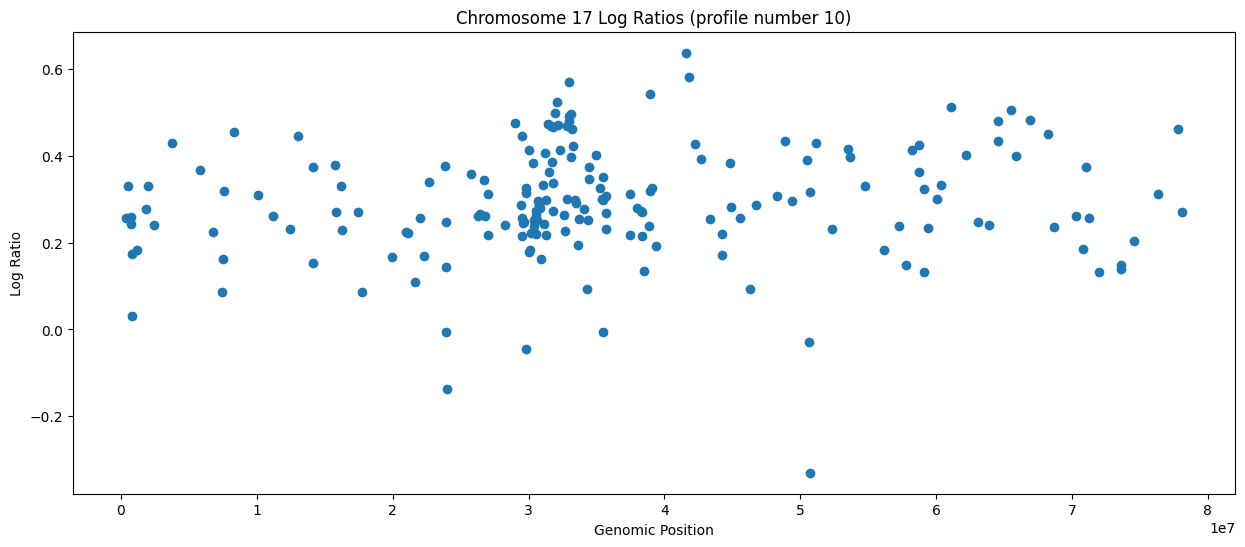

In [ ]:
chromosome = 17
profile_id = 10

plt.figure(figsize=(15, 6))
# Filter for the desired chromosome
sub_df = df[(df['chromosome'] == str(chromosome)) & ( df["profile.id"] == str(profile_id))].copy()

# Sort by genomic position
sub_df.sort_values(by='position', inplace=True)

# Plot log ratios vs. position
plt.scatter(sub_df['position'], sub_df['logratio'], marker='o')
plt.xlabel('Genomic Position')
plt.ylabel('Log Ratio')
plt.title(f'Chromosome {chromosome} Log Ratios (profile number {profile_id})')

# Display the plot
plt.show()

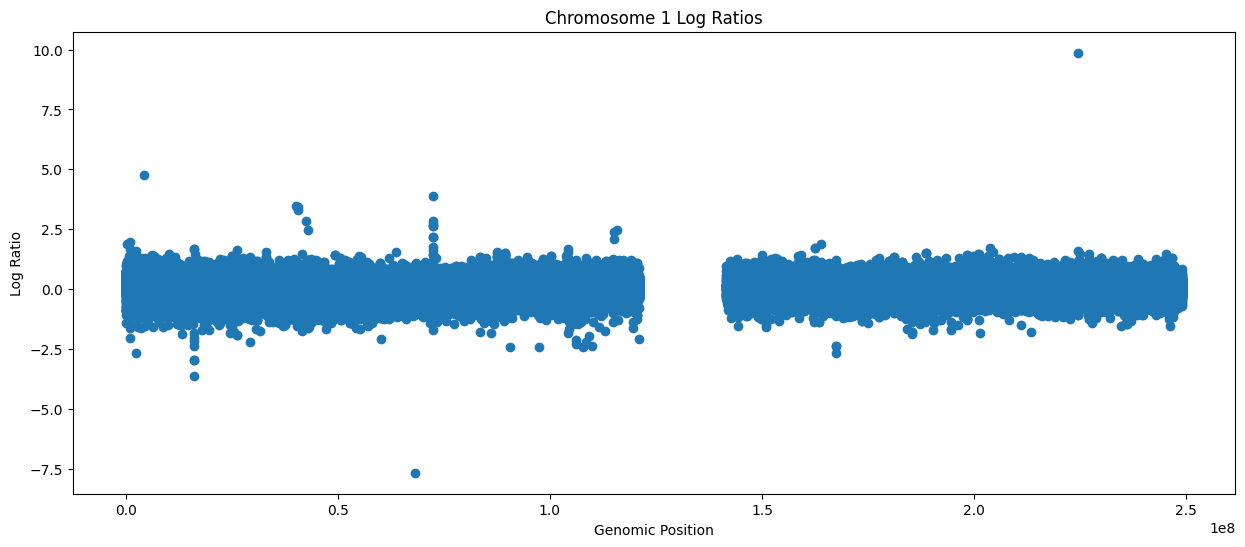

In [ ]:
chromosome = 1

plt.figure(figsize=(15, 6))
# Convert chromosome column to string if necessary for consistent filtering
df['chromosome'] = df['chromosome'].astype(str)

# Filter for the desired chromosome
sub_df = df[df['chromosome'] == str(chromosome)].copy()

# Sort by genomic position
sub_df.sort_values(by='position', inplace=True)

# Plot log ratios vs. position
plt.scatter(sub_df['position'], sub_df['logratio'], marker='o')
plt.xlabel('Genomic Position')
plt.ylabel('Log Ratio')
plt.title(f'Chromosome {chromosome} Log Ratios')

# Display the plot
plt.show()

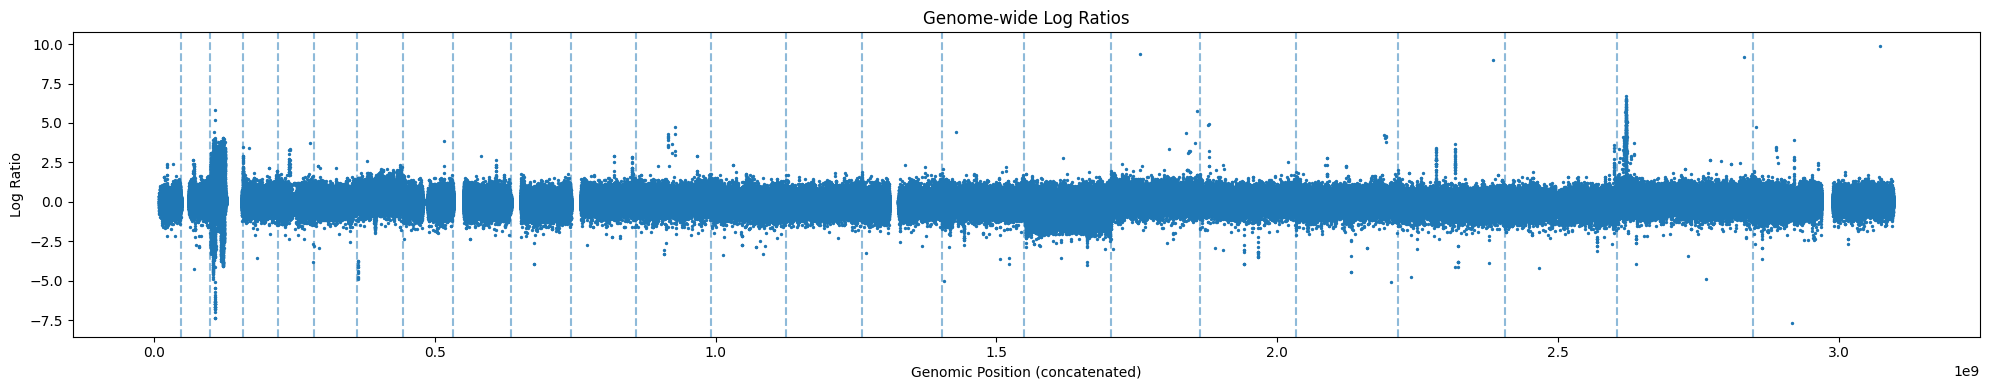

In [ ]:
#    Sort the DataFrame by chromosome *and then* position.
#    If your chromosomes are just numeric (e.g. "1","2","3"), you can sort
#    them as integers. If you have "X","Y","MT", you'll need a custom sort.
#    For purely numeric "1","2",..., do:
df.sort_values(['chromosome', 'position'], inplace=True)

#    Compute an offset for each chromosome so they can be placed end to end.
#    We’ll group by chromosome, find the max position in each chromosome,
#    then compute the cumulative offset across chromosomes.
chr_max_position = df.groupby('chromosome')['position'].max().sort_values()

# We'll accumulate an offset so that chromosome 1 starts at 0,
# chromosome 2 starts at the end of chromosome 1, etc.
offsets = {}
running_offset = 0

for c, max_pos in chr_max_position.items():
    offsets[c] = running_offset
    running_offset += max_pos  # add the length of that chromosome

#    Create a new column 'genome_position' for a single continuous scale.
df['genome_position'] = df.apply(
     lambda row: row['position'] + offsets[row['chromosome']], axis=1
)

# 6. Plot log ratio vs. genome_position
plt.figure(figsize=(20, 4))  # pick any size you like
plt.scatter(df['genome_position'], df['logratio'], s=2)
plt.xlabel('Genomic Position (concatenated)')
plt.ylabel('Log Ratio')
plt.title('Genome-wide Log Ratios')

# Optionally, draw vertical lines to separate chromosomes
# We'll draw a line at the transition from each chromosome to the next.
for c in chr_max_position.index[1:]:  # start from second chrom
    x = offsets[c]  # offset at which this chromosome starts
    plt.axvline(x=x, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Dataset Creation


In [ ]:
df_tot = df.merge(
    df_annotation,
    on=["profile.id", "chromosome"],
    how="left"
    )

# check if there are some position before 'min' or after 'max'
df_tot["anomaly"] = np.where(
    (df_tot.position < df_tot["min"]) | (df_tot.position > df_tot["max"]),
    1,
    0
)

In [ ]:
len(df_tot)

4616846

In [ ]:
# Most of the Nan are in specific chromosome
pd.crosstab(
    df_tot.annotation,
    df_tot.chromosome,
    dropna=False
)

chromosome,1,10,11,12,13,14,15,16,17,18,...,22,3,4,5,6,7,8,9,X,Y
annotation,,,,,,,,,,,,,,,,,,,,,
breakpoint,74447,0,30184,0,0,0,0,0,41452,0,...,0,23617,10881,0,0,0,0,0,0,0
normal,397077,0,177455,0,0,0,0,0,126169,0,...,0,282999,264386,0,0,0,0,0,0,0
NaN,3905,205082,665,235844,143019,135611,124801,124813,2124,115315,...,75745,205,1210,276647,250540,220701,222656,181837,213181,35516


In [ ]:
extractor = LogRatioExtractor(df_tot, profile=False, drop_anomaly=True, annotation=["breakpoint"])
logratio_dict, _ = extractor.get_logratio_dict()

# CUSUM for annotated regions

First, we take the code from the GitHub repository for the efficient CUSUM NumPy computation.

In [ ]:
def cusum_generic(y, sigma, beta, min_seg=1):
    """
    Compute the CUSUM statistic over all candidate changepoints.
    If min_seg is provided, only candidate changepoints leaving at least
    min_seg observations in each segment are considered.
    """
    n = len(y)
    if n < 2*min_seg:
        return np.nan, 0.0, np.array([])

    mean_left      = (np.cumsum(y) / np.arange(1, n+1))[min_seg-1:n-min_seg]
    mean_right     = (np.cumsum(y[::-1]) / np.arange(1, n+1))[min_seg-1:n-min_seg][::-1]
    scaling_factor = np.arange(min_seg, n-min_seg+1) * np.arange(n-min_seg, min_seg-1, -1) / n
    C2_seq         = scaling_factor * (mean_left - mean_right)**2
    tau_hat        = np.argmax(C2_seq)
    C2_max         = C2_seq[tau_hat]


    if C2_max / sigma**2 > beta:
        return tau_hat+1, C2_max, C2_seq
    else:
        return np.nan, C2_max, C2_seq

**Sanity check**

In this section, we simulate a time series without a changepoint and evaluate the ability of the CUSUM algorithm to detect it, given a certain configuration. The *simulate_stream* function generates a sequence of synthetic data following a Gaussian distribution. This allows us to create a dataset on which to test the absence of a detection in an ideal context, since on real data the distribution may deviate from normality. Next, the *mc_routine* function runs a Monte Carlo simulation to estimate the probability of correctly not detecting the change. At each iteration, a new time series is generated, and the standard deviation is estimated with the absolute median of deviations (MAD). The CUSUM algorithm is then applied to search for a possible change point (that we know is not there), using a threshold based on the Gaussian concentration and adjusted according to Bonferroni correction to control for type II error.

We did that because type II control based on the Gaussian assumption was not realistic when looking at the real data we are using, and we wanted to be sure that we did not make any mistake while implementing the procedure.

In [ ]:
def simulate_stream(n_points: int, index_change: int,
                    init_mean: float, init_variance: float,
                    change_size_mean: float, change_variance: float,
                    seed: int):
    generator = np.random.default_rng(seed)
    gaussian_data_normal = generator.normal(init_mean, np.sqrt(init_variance), index_change)
    gaussian_data_change = generator.normal(init_mean + change_size_mean,
                                            np.sqrt(init_variance + change_variance),
                                            n_points-index_change)
    return np.concatenate((gaussian_data_normal, gaussian_data_change))

In [ ]:
def mc_routine(mc_iterations:int):
  out_array = np.zeros(shape = mc_iterations, dtype = np.float32)
  for i in tqdm(range(mc_iterations)):
    data = simulate_stream(200, 90, 1, 1, 0, 0, i)
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(10**-2))[0]

  return np.mean(~np.isnan(out_array))

out = mc_routine(1000)

100%|██████████| 1000/1000 [00:00<00:00, 3995.26it/s]


In [ ]:
out

np.float64(0.002)

As we can see, in this case a $10^{-2}$ type II error control is actually enforced, meaning that the procedure - even though conservative for obvious theorical reasons - is correct.

## CUSUM for control regions
We read control data, i.e. data annotated as normal: we do not expect to find breakpoints there, so here we only want to check type II error.

In [ ]:
extractor = LogRatioExtractor(df_tot, profile=False, drop_anomaly=True, annotation=["normal"])
logratio_dict_control = extractor.get_logratio_dict()[0]

Here we consider the analytic threshold given by gaussian concentration together with the union bound. We consider a sequence of type II error control values, ranging from $5*10^{-10}$ to $5*10^{-2}$ with a grid of 1000 values. Clearly the theoretical $\alpha$ control here may be not enforced since the gaussian assumption on this type of real data may not be fitting, as we were anticipating earlier, even with the very strict Bonferroni correction. We check the discrepancy between the theoretical and actual type II error control with a plot.

In [ ]:
# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the theoretical false positive rate (FPR) for each alpha value.
out_alpha_fpr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds.
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  out_array = np.zeros(len(logratio_dict_control), dtype = np.float32)

  # Loop over time/genome series
  for i, key in enumerate(logratio_dict_control):
    data = logratio_dict_control[key]
    # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha))[0]

  # Calculate the proportion of control series where a (false) changepoint was detected.
  # This gives the False Positive Rate for the current alpha value.
  out_alpha_fpr[j] = np.mean(~np.isnan(out_array))

100%|██████████| 200/200 [01:42<00:00,  1.94it/s]


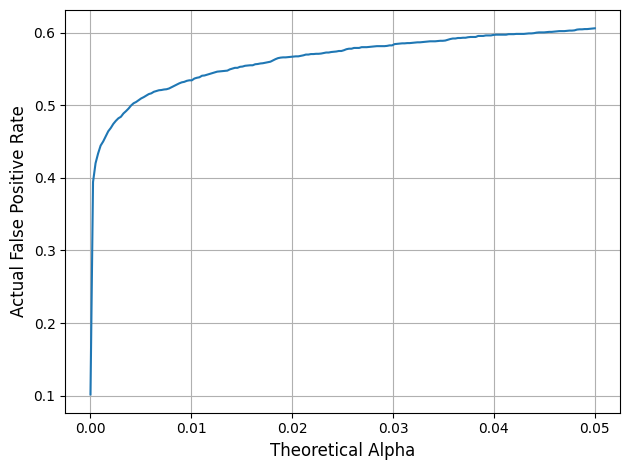

In [ ]:
plt.plot(alpha_array, out_alpha_fpr)
plt.xlabel('Theoretical Alpha', fontsize=12)
plt.ylabel('Actual False Positive Rate', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

As anticipated, type II error control is very weak and decays fast for reasonable values of $\alpha$.

#CUSUM for breakpoint regions
We read positive data, i.e. data annotated as having a breakpoint/anomaly: here the only thing we expect to check is type I error (i.e. the complementary value of power) with varying $\alpha$.

In [ ]:
extractor = LogRatioExtractor(df_tot, profile=False, drop_anomaly=True, annotation=["breakpoint"])
logratio_dict_break = extractor.get_logratio_dict()[0]

The setting is the same as before, in terms of threshold chosen and sequence of $\alpha$ values considered.

In [ ]:
# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the false negative rate for each alpha value.
out_alpha_fnr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  # Initialize an array to store the CUSUM results for each "break" time series
  out_array = np.zeros(len(logratio_dict_break), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_break):
    data = logratio_dict_break[key]
     # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499

    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha))[0]

  # Calculate the proportion of series where no change was detected (NaN result) representing the False Negative Rate (FNR) for this alpha value.
  out_alpha_fnr[j] = np.mean(np.isnan(out_array))

100%|██████████| 200/200 [00:21<00:00,  9.27it/s]


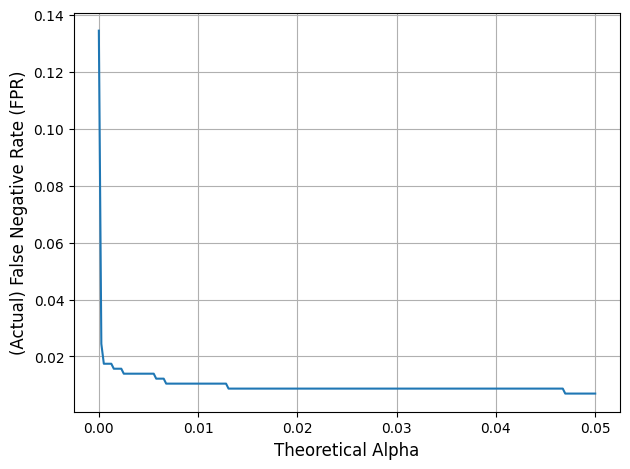

In [ ]:
plt.plot(alpha_array, out_alpha_fnr)
plt.xlabel('Theoretical Alpha', fontsize=12)
plt.ylabel('(Actual) False Negative Rate (FPR)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

This plot somewhat complements what we said above, since power is very high almost independently of $\alpha$.

The following plot zooms into one specific time series to inspect the performance of the CUSUM detection, to let us visually verify if the algorithm correctly identifies the changepoint (red vertical dashed line).

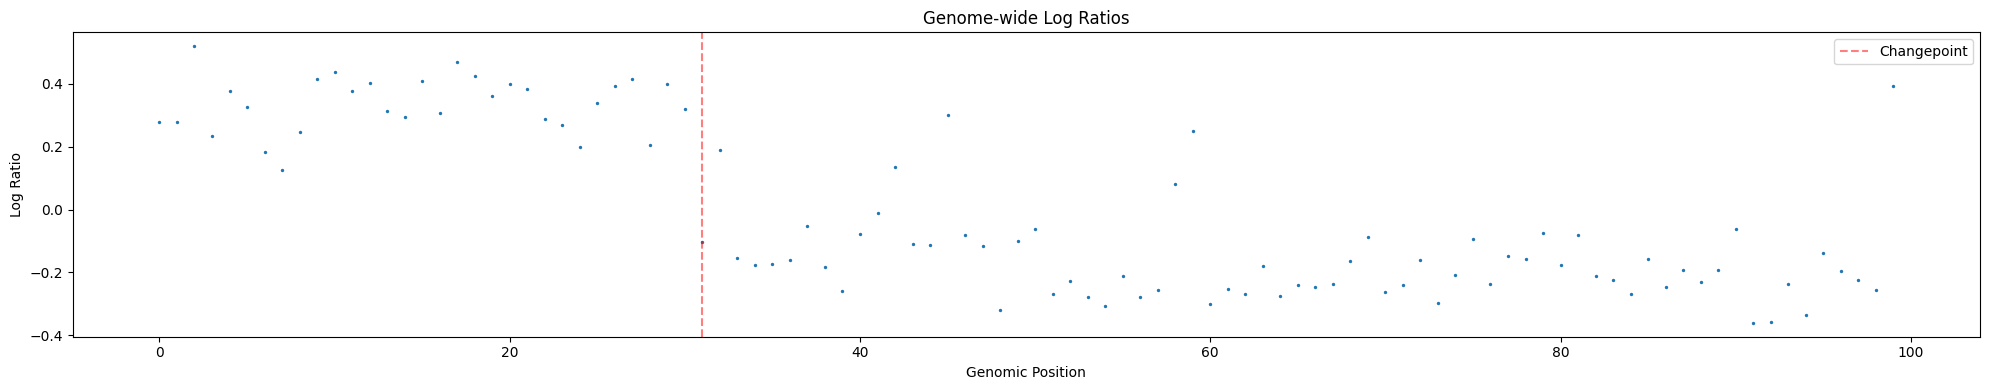

In [ ]:
# Extract a specific time series from the "break" dataset
data = logratio_dict_break['1_11']
# Estimate the standard deviation using MAD and run CUSUM
sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
position, _, C2_seq = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(10**-3))
# Plot the time series alongside the detected changepoint
plot_genome_logratios(data, [position])

The following cell provides a clear, visual representation of how the CUSUM statistic behaves across the data. The dashed vertical line indicates where the algorithm detected a change. Since the changepoint is correctly identified, the curve
show a sharp peak at that position, highlighting a significant shift in the data.

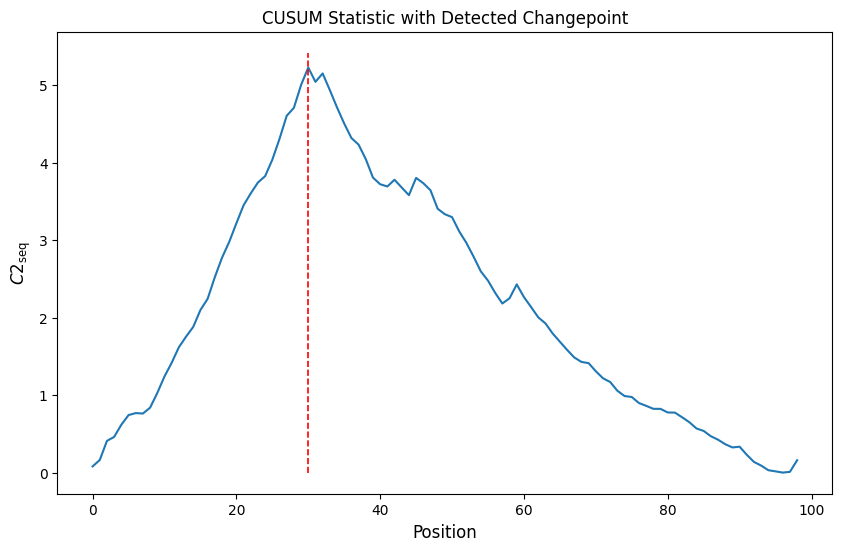

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)-1), C2_seq)
plt.vlines(position-1, 0, np.max(C2_seq)+1/np.max(C2_seq), linestyle = 'dashed', color = 'red', linewidth = 1.2)
plt.xlabel('Position', fontsize=12)
plt.ylabel('$C2_{\\text{seq}}$', fontsize=12)
plt.title('CUSUM Statistic with Detected Changepoint', fontsize=12)
plt.show()

Below you can visualize the results obtained on another specific time series.

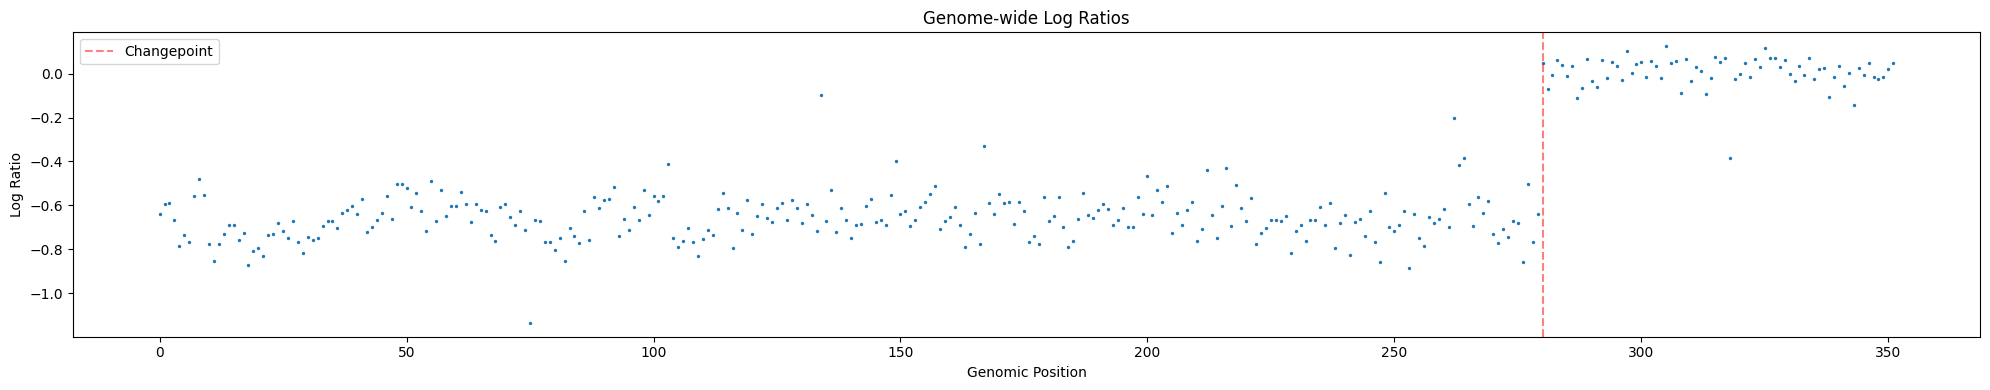

In [ ]:
data = logratio_dict_break['102_1']
sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
position, _, C2_seq = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(10**-3))
plot_genome_logratios(data, [position])

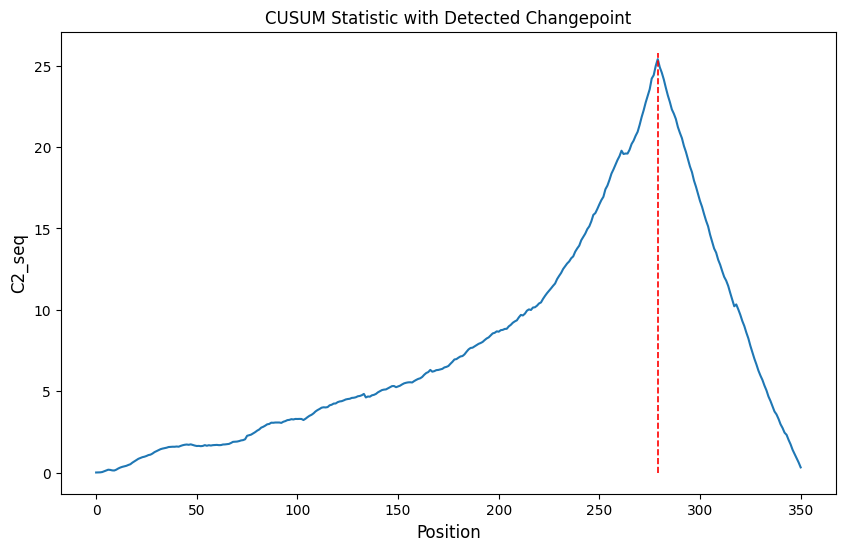

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(data)-1), C2_seq)
plt.vlines(position-1, 0, np.max(C2_seq)+10/np.max(C2_seq), linestyle = 'dashed', color = 'red', linewidth = 1.2)
plt.xlabel('Position', fontsize=12)
plt.ylabel('$C2_{\\text{seq}}$', fontsize=12)
plt.title('CUSUM Statistic with Detected Changepoint', fontsize=12)
plt.show()

## CUSUM with minimum segment length constraint for control regions

In this section and in the following one we're going to introduce a minimum segment length constraint and check the error control for both regions. In particular, we picked as length values $[5, 10, 20]$ in both cases. You can find some considerations on the result for control regions at the and of the section.

First experiment: minimum segment length = 5

In [ ]:
min_seg_len = 5
# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the theoretical false positive rate (FPR) for each alpha value.
out_alpha_fpr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds.
for j, alpha in tqdm(
    enumerate(alpha_array),
    total = len(alpha_array)
    ):
  out_array = np.zeros(len(logratio_dict_control), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_control):
    data = logratio_dict_control[key]
    # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of control series where a (false) changepoint was detected.
  # This gives the False Positive Rate for the current alpha value.
  out_alpha_fpr[j] = np.mean(~np.isnan(out_array))

100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


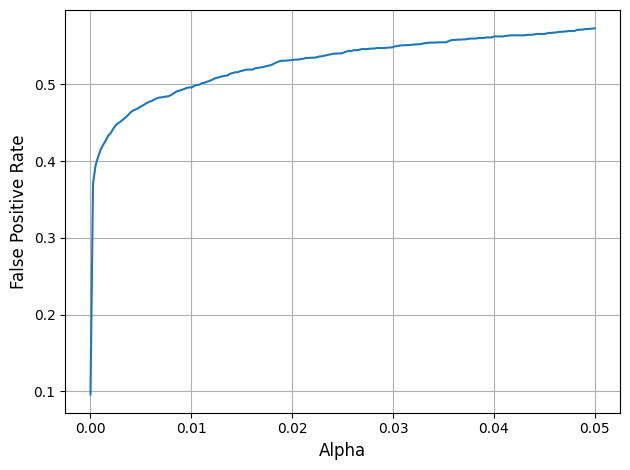

In [ ]:
plt.plot(alpha_array, out_alpha_fpr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Positive Rate', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Second experiment: minimum segment length = 10

In [ ]:
min_seg_len = 10

# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the theoretical false positive rate (FPR) for each alpha value.
out_alpha_fpr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds.
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  out_array = np.zeros(len(logratio_dict_control), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_control):
    data = logratio_dict_control[key]
    # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of control series where a (false) changepoint was detected.
  # This gives the False Positive Rate for the current alpha value.
  out_alpha_fpr[j] = np.mean(~np.isnan(out_array))

100%|██████████| 200/200 [01:45<00:00,  1.90it/s]


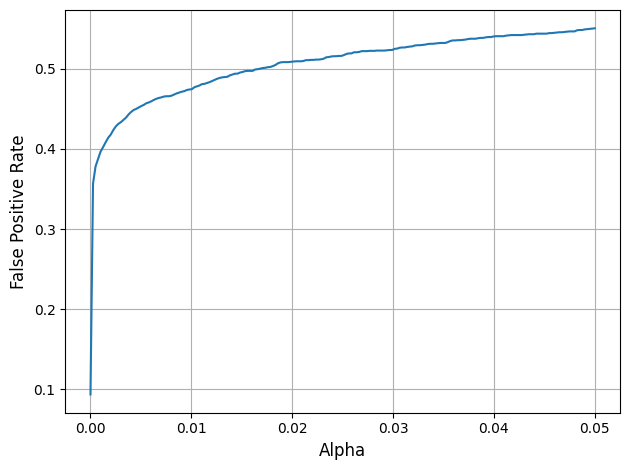

In [ ]:
plt.plot(alpha_array, out_alpha_fpr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Positive Rate', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Third experiment: minimum segment length = 20

In [ ]:
min_seg_len = 20

# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the theoretical false positive rate (FPR) for each alpha value.
out_alpha_fpr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds.
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  out_array = np.zeros(len(logratio_dict_control), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_control):
    data = logratio_dict_control[key]
    # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of control series where a (false) changepoint was detected.
  # This gives the False Positive Rate for the current alpha value.
  out_alpha_fpr[j] = np.mean(~np.isnan(out_array))

100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


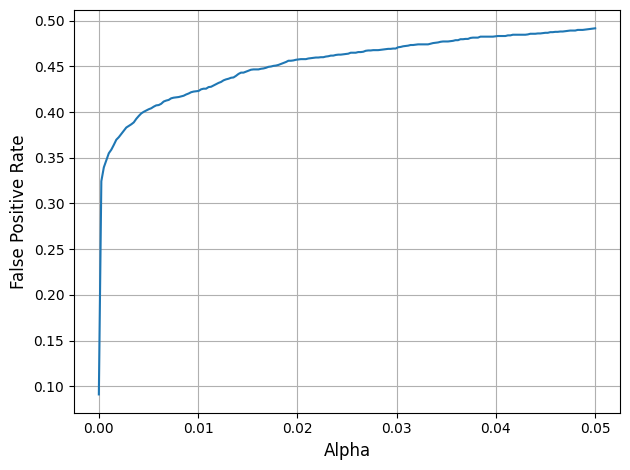

In [ ]:
plt.plot(alpha_array, out_alpha_fpr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Positive Rate', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Although type II error control still remains very weak and rapidly decays, we can observe from the four plots that increasing the minimum segment length causes the False Positive Rate (FPR) to remain confined to a somewhat smaller range. Specifically, in the first plot (where the minimum length is equal to $1$), the FPR rises slightly above $0.6$. However, it stays between $0.5$ and $0.6$ when the minimum length is set to $5$ and $10$, and it no longer exceeds $0.5$ when we increase the length to $20$.

## CUSUM with minimum segment length constraint for breakpoint regions

Now we evaluate the performace of the CUSUM algorithm with minimum segment length for breakpoints regions.

First experiment: minimum segment length = 5

In [ ]:
min_seg_len = 5

# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the false negative rate for each alpha value.
out_alpha_fnr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  # Initialize an array to store the CUSUM results for each "break" time series
  out_array = np.zeros(len(logratio_dict_break), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_break):
    data = logratio_dict_break[key]
     # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499

    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of series where no change was detected (NaN result) representing the False Negative Rate (FNR) for this alpha value.
  out_alpha_fnr[j] = np.mean(np.isnan(out_array))

100%|██████████| 200/200 [00:20<00:00,  9.58it/s]


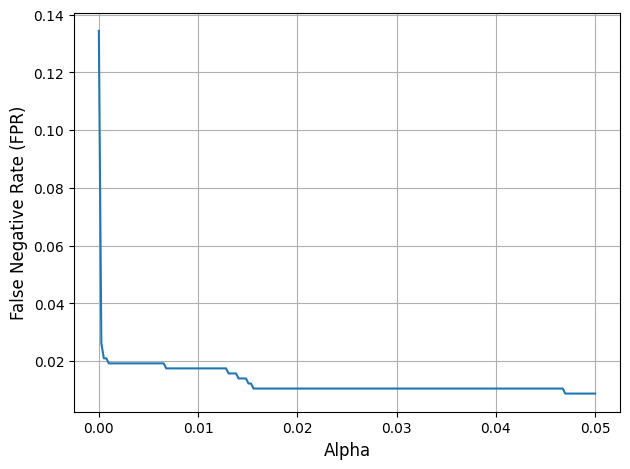

In [ ]:
plt.plot(alpha_array, out_alpha_fnr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Negative Rate (FPR)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Second experiment: minimum segment length = 10

In [ ]:
min_seg_len = 10

# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the false negative rate for each alpha value.
out_alpha_fnr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  # Initialize an array to store the CUSUM results for each "break" time series
  out_array = np.zeros(len(logratio_dict_break), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_break):
    data = logratio_dict_break[key]
     # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499

    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of series where no change was detected (NaN result) representing the False Negative Rate (FNR) for this alpha value.
  out_alpha_fnr[j] = np.mean(np.isnan(out_array))

100%|██████████| 200/200 [00:21<00:00,  9.33it/s]


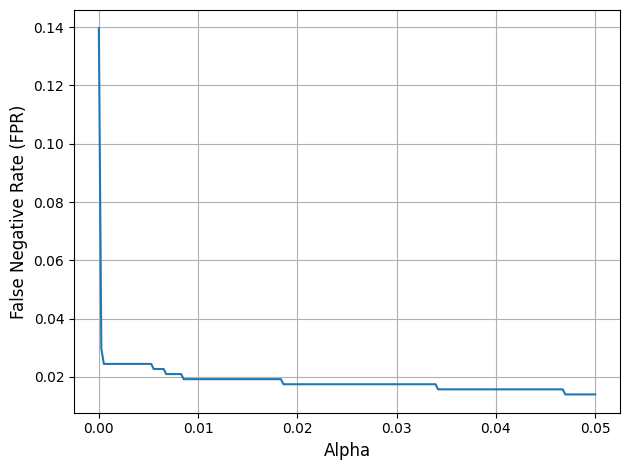

In [ ]:
plt.plot(alpha_array, out_alpha_fnr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Negative Rate (FPR)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Third experiment: minimum segment length = 20

In [ ]:
min_seg_len = 20

# Create an array of alpha values
alpha_array = np.linspace(5*10**-20, 5*10**-2, 200)

# Initialize an array to store the false negative rate for each alpha value.
out_alpha_fnr = np.zeros(len(alpha_array), dtype = np.float32)

# Loop over each alpha value to test different thresholds
for j, alpha in tqdm(enumerate(alpha_array), total = len(alpha_array)):
  # Initialize an array to store the CUSUM results for each "break" time series
  out_array = np.zeros(len(logratio_dict_break), dtype = np.float32)

  # Loop over time series
  for i, key in enumerate(logratio_dict_break):
    data = logratio_dict_break[key]
     # Estimate the standard deviation using the MAD, adjusted to be compatible with the standard deviation of a Gaussian distribution.
    sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499

    # Apply the CUSUM function.
    # If a change is detected, the result is the changepoint index, otherwise NaN.
    out_array[i] = cusum_generic(data, sd_estimate, 2*np.log(len(data)-1)-2*np.log(alpha), min_seg = min_seg_len)[0]

  # Calculate the proportion of series where no change was detected (NaN result) representing the False Negative Rate (FNR) for this alpha value.
  out_alpha_fnr[j] = np.mean(np.isnan(out_array))

100%|██████████| 200/200 [00:20<00:00,  9.71it/s]


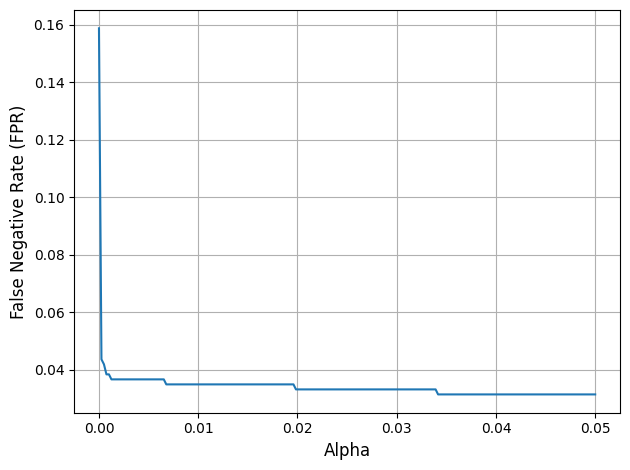

In [ ]:
plt.plot(alpha_array, out_alpha_fnr)
plt.xlabel('Alpha', fontsize=12)
plt.ylabel('False Negative Rate (FPR)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Again, the results are in line with previous results.

## Calibration of the threshold



The goal is to understand how the CUSUM threshold affects the false positive rate on control data.
This setup helps us choose a threshold that is actually enough to get only up to the needed level of type II error control, something crucial in order to avoid overly conservative changepoint detection.

In [ ]:
# Pick a subset of control data
num_data = len(logratio_dict_control)
generator = np.random.default_rng(1234)
subset = generator.choice(np.arange(num_data, dtype = np.int32),
                          size = math.floor(0.3*num_data),
                          replace = False)
# Initialize the false positive rate array
fpr_array = np.zeros(1000, dtype = np.float32)
# Sweep through threshold, run CUSUM and evaluate false positives on the control data subset
for j, threshold in enumerate(tqdm(np.linspace(10**-2, 200, 1000), total = 1000)):
  k = 0
  out_array = np.zeros(math.floor(0.3*num_data), dtype = np.float32)
  for i, key in enumerate(logratio_dict_control):
    if np.isin(i, subset):
        data = logratio_dict_control[key]
        sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
        out_array[k] = cusum_generic(data, sd_estimate, threshold)[0]
        k += 1
  # Compute FPR for the current treshold
  fpr_array[j] = np.mean(~np.isnan(out_array))

 38%|███▊      | 375/1000 [01:58<03:39,  2.85it/s]

In [ ]:
plt.plot(np.linspace(10**-2, 200, 1000), fpr_array)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('False Positive Rate (FPR)', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

Now we select a calibrated threshold according to the false positive rate analysis we just ran. Then we perform a final evaluation of the calibrated threshold on the remaining 70% of control data that wasn’t used during calibration.

In [ ]:
# Calibration choice
calibrated_thres = np.linspace(10**-2, 200, 1000)[np.where(fpr_array<=0.05)[0][0]]

In [ ]:
out_array = np.zeros(num_data - math.floor(0.3*num_data), dtype = np.float32)
k = 0
for i, key in enumerate(logratio_dict_control):
  if not np.isin(i, subset):
      data = logratio_dict_control[key]
      sd_estimate = mad_estimate(np.diff(data)/np.sqrt(2))/0.67499
      out_array[k] = cusum_generic(data, sd_estimate, calibrated_thres)[0]
      k += 1
print(np.round(np.mean(~np.isnan(out_array)), 3))

We can see that this way we actually reliably recover the needed level of type II control.

# Multiple Change-Point Detection

Now, we begin the multiple change-point detection process. To ensure the notebook executes within a reasonable amount of time, we consider only the first 217 profiles.

In [ ]:
df_tot = df_tot.query( " `profile.id` < '300' " )

In [ ]:
len(df_tot["profile.id"].unique())

217

We instanciate the dataset, this time using the *profile* set to *True* to have the logratios aggregated for entire profile.

In [ ]:
extractor = LogRatioExtractor(
    df_tot,
    profile=True,
    drop_anomaly=False,
    annotation=["normal", "breakpoint"]
    )
logratio_dict, annotation_dict, chromosome_starts = extractor.get_logratio_dict()

## MAD Estimator
We begin by applying the standard Optimal Partitioning algorithm, using the MAD estimator to estimate the variance. The first 10 profiles are displayed (using the *plot_genome_logratios* function). Dashed red lines indicate changepoints, while black vertical lines represent the intersections of different chromosomes.

We use the *filter_changepoints* function to prevent the identification of changepoints caused by chromosome transitions. If a changepoint is detected within ±20 points around a breakpoint, it is disregarded.

Visually the algorithm seems to work fine, without more complex techniques.

  0%|          | 0/217 [00:00<?, ?it/s]

Key: 1
Changepoints: [187 437 560]
Min cost: -150.71088350665502


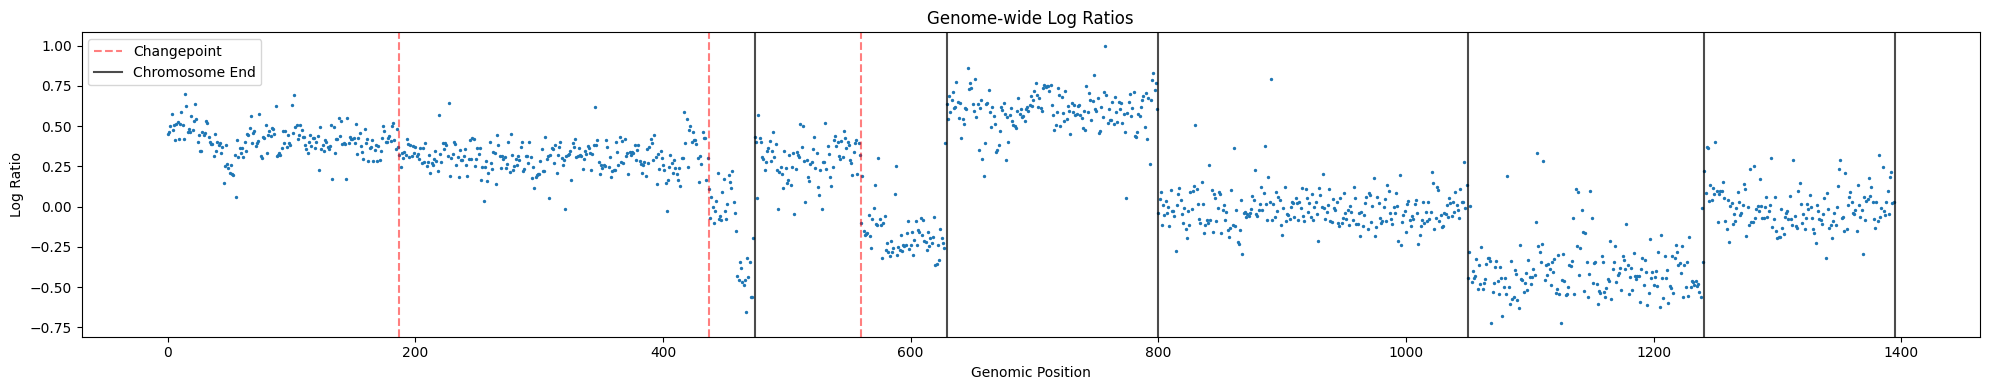

  0%|          | 1/217 [00:01<04:53,  1.36s/it]

Key: 10
Changepoints: []
Min cost: -43.76687893781205


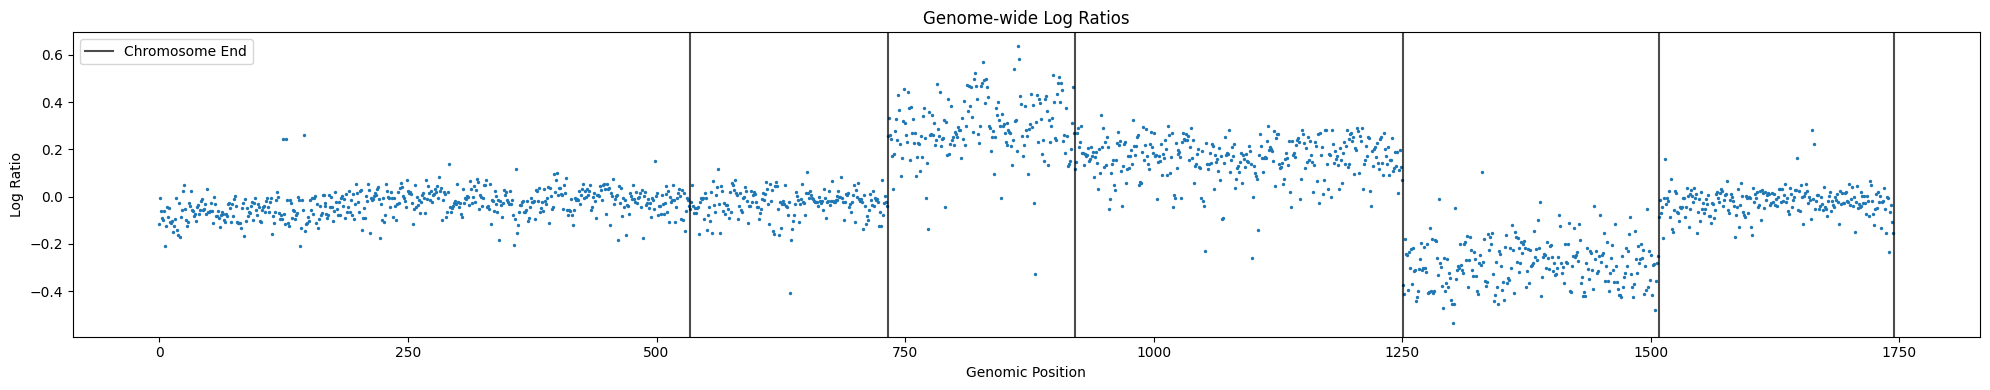

  1%|          | 2/217 [00:03<07:31,  2.10s/it]

Key: 100
Changepoints: []
Min cost: -4.69120710745279


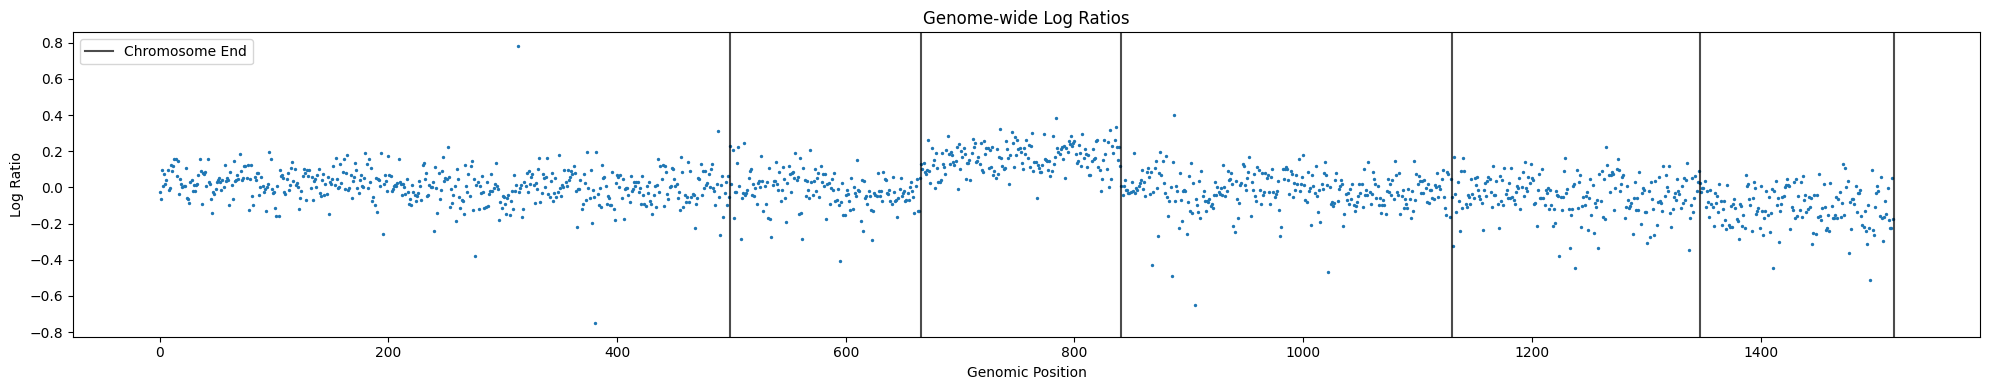

  1%|▏         | 3/217 [00:06<07:31,  2.11s/it]

Key: 101
Changepoints: [881 882 883]
Min cost: -149.4703159988584


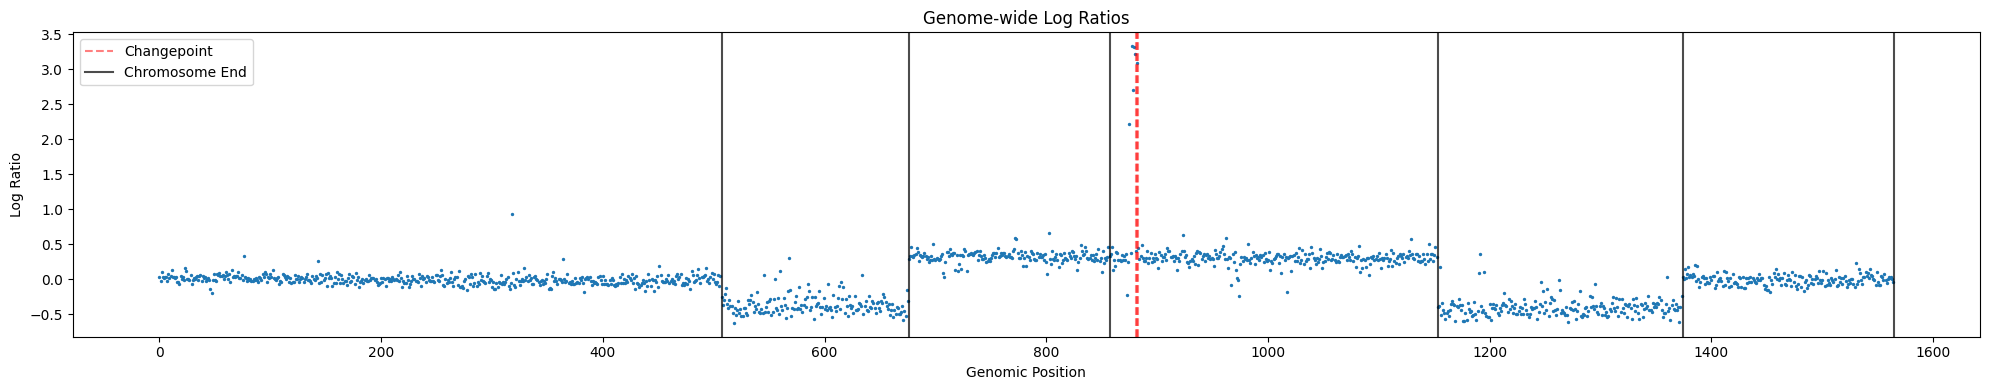

  2%|▏         | 4/217 [00:07<06:49,  1.92s/it]

Key: 102
Changepoints: [280 829 914]
Min cost: -143.34839171377976


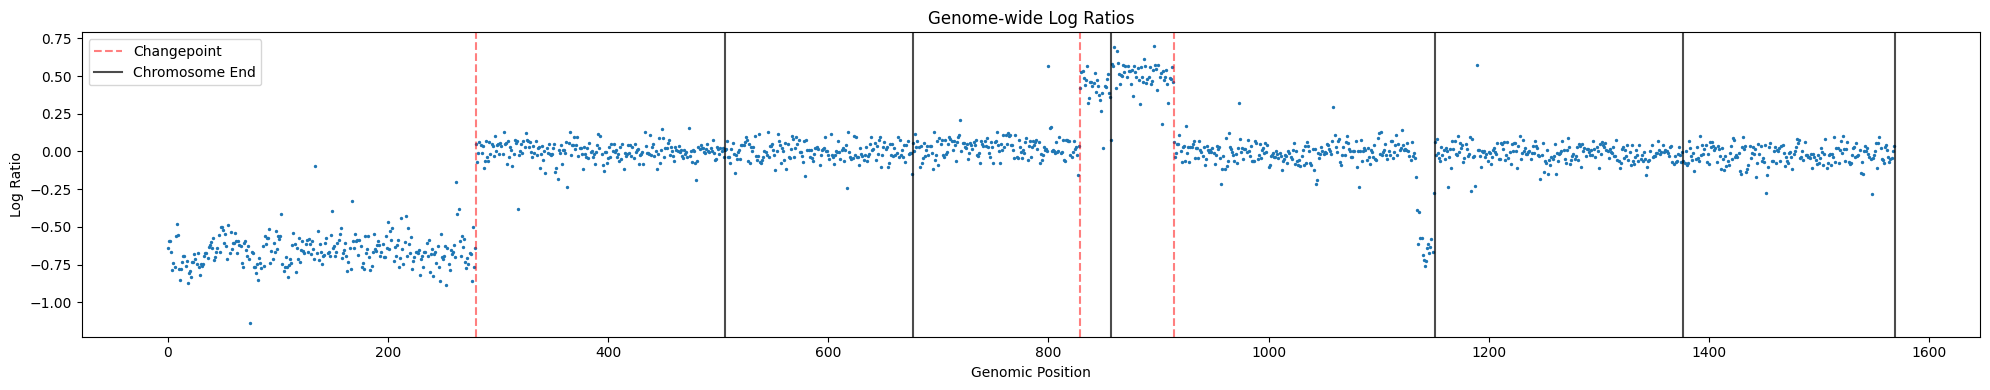

  2%|▏         | 5/217 [00:09<06:25,  1.82s/it]

Key: 103
Changepoints: [244 428 741 820 823]
Min cost: -267.75596263860496


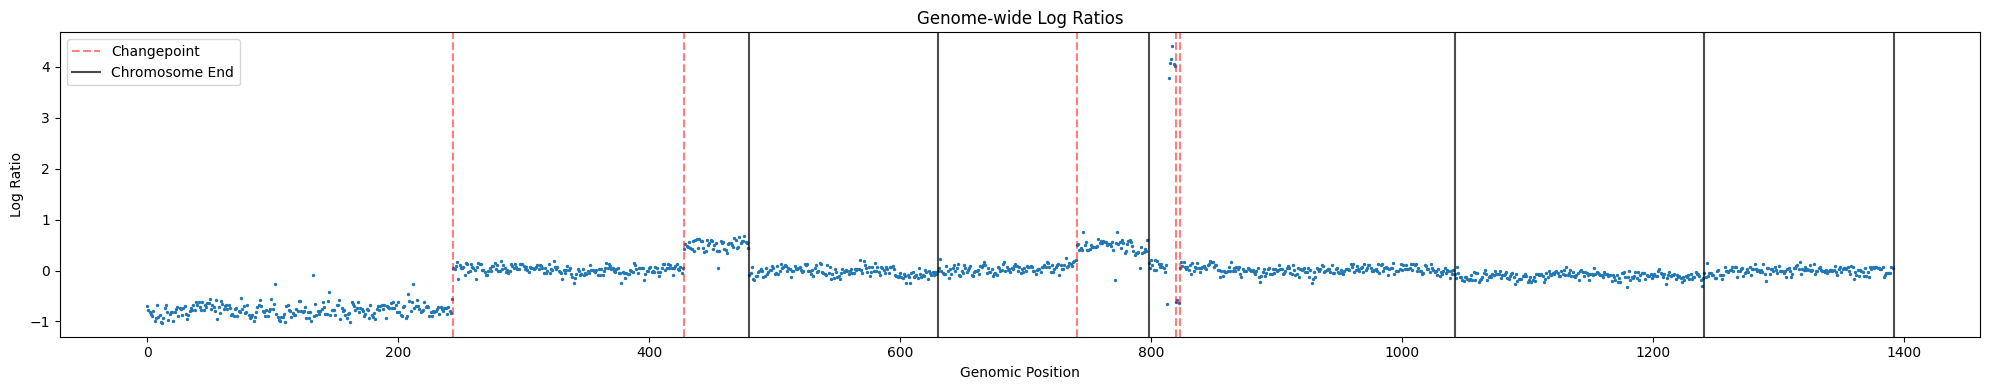

  3%|▎         | 6/217 [00:10<05:47,  1.65s/it]

Key: 104
Changepoints: [189 694 718 768 823]
Min cost: -152.7209669369359


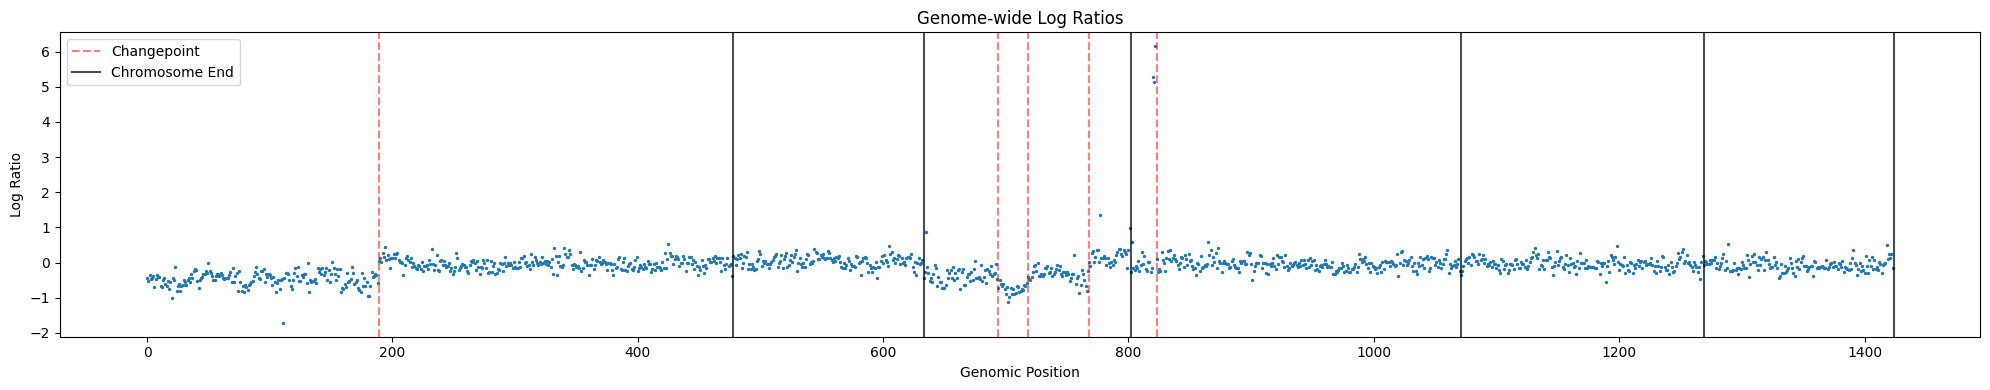

  3%|▎         | 7/217 [00:12<05:37,  1.61s/it]

Key: 105
Changepoints: []
Min cost: -5.201358313604933


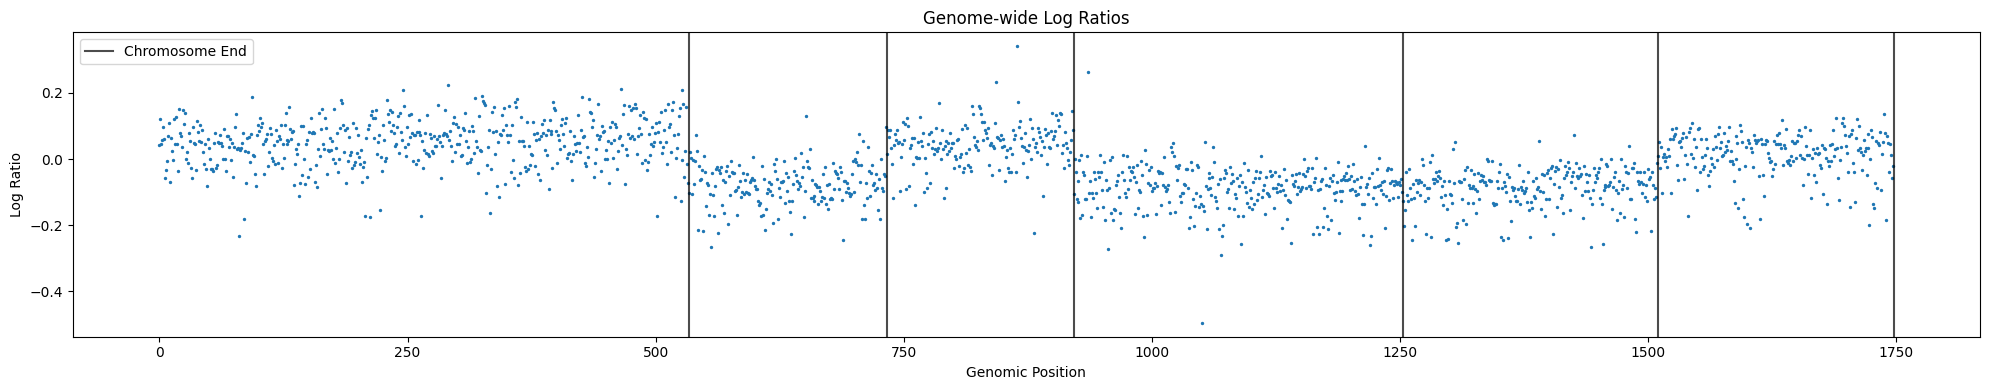

  4%|▎         | 8/217 [00:15<07:56,  2.28s/it]

Key: 106
Changepoints: [640 861]
Min cost: -48.081987733822224


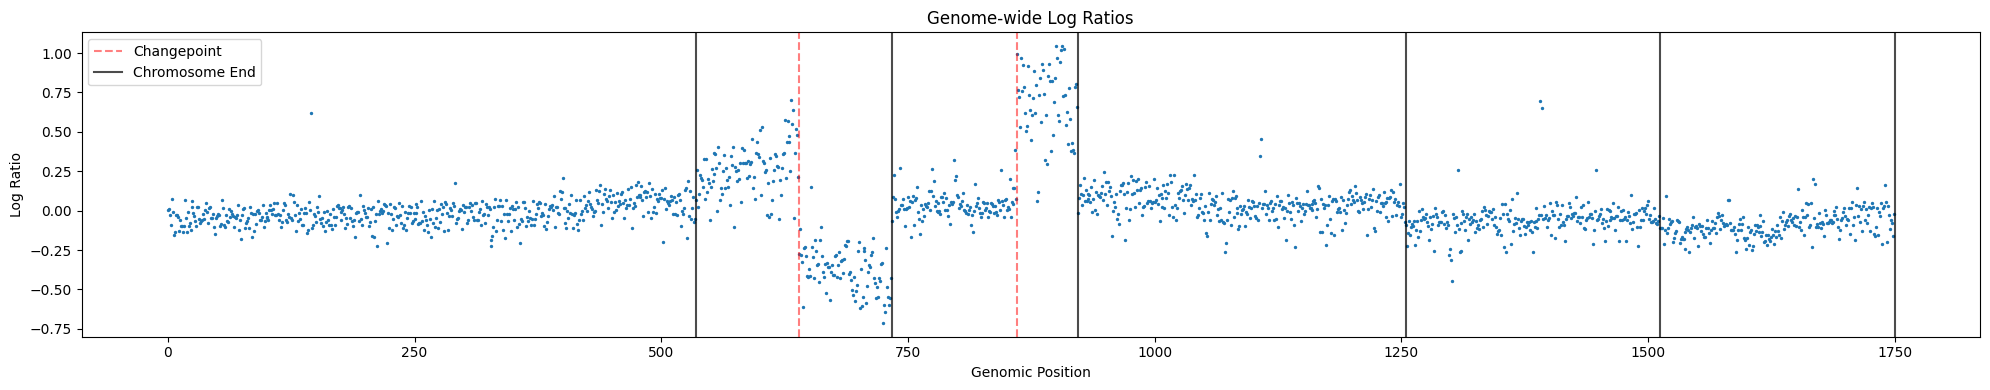

  4%|▍         | 9/217 [00:18<08:34,  2.47s/it]

Key: 107
Changepoints: []
Min cost: -36.655427848980636


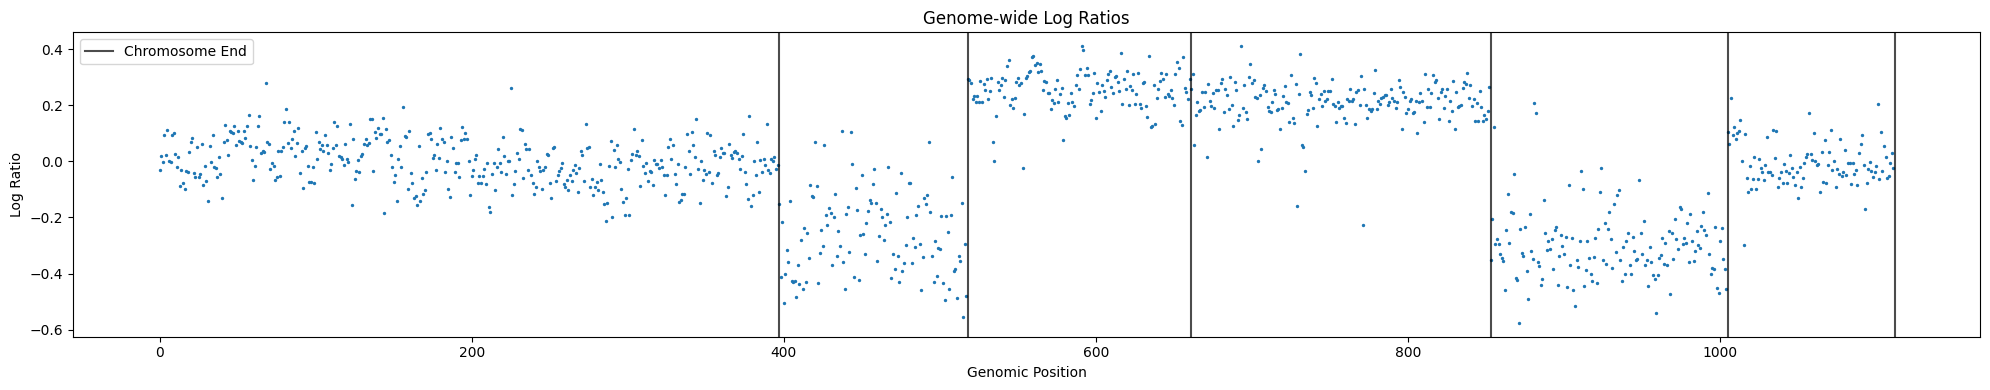

100%|██████████| 217/217 [12:03<00:00,  3.33s/it]


In [ ]:
changepoints_identified = {}

for index, (key, chromosome_start_key) in tqdm(
    enumerate(
        zip(list(logratio_dict.keys()), list(chromosome_starts.keys()))
        ), total=len(logratio_dict)):

  data = logratio_dict[str(key)]
  chromosome_start = chromosome_starts[str(chromosome_start_key)]

  sigma = mad_estimate(np.diff(data)/np.sqrt(2))

  op = OptimalPartitioning(
      penalty = 2*sigma*np.log(len(data)),
      cost_func = GaussianCPInMeanCost()
  )
  op.fit(data)

  changepoints = op.get_changepoints()

  # do not consider the changepoint that are due to the start of a new chromosome
  changepoints = filter_changepoints(changepoints, chromosome_start)
  # save the changepoint identified
  changepoints_identified[str(key)] = changepoints

  if index < 10:
    print(f"Key: {key}")
    print("Changepoints:", changepoints)
    print("Min cost:", op.get_min_cost())
    plot_genome_logratios(
      data,
      changepoints,
      chromosome_start
      )

Then we use the *calculate_preformance* function to evaluate the performance of the algorithm in term of I and II errors.

On the first 217 profile we overlook only one change-point ( 1 FN - type II error) and we indentify 33 changepoints where there are no (33 FP - type I error).

Instead, the vast majority of profiles are correctly classified as *normal* ( 74 TN ) or with *breakpoint* ( 109 TP ).


In [ ]:
performance = calculate_preformance(
    annotation_dict,
    changepoints_identified
)
performance

{'TP': 109, 'FP': 33, 'FN': 1, 'TN': 74}

Then we calculate the error rates.

### False Positive Rate (FPR)
$$
\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TP}}
$$

The FPR was **0.23**, which is lower compared to most of the thresholds used for the single-chromosome scenario.

### False Negative Rate (FNR)
$$
\text{FNR} = \frac{\text{FN}}{\text{FN} + \text{TN}}
$$

The FNR was **0.01**, which is almost zero.

Similar to what happens in the case of single change-point detection, the FPR is much higher compared to the FNR.

In [ ]:
performance['FP'] / ( performance['FP'] + performance['TP'] )

0.2323943661971831

In [ ]:
performance['FN'] / ( performance['FN'] + performance['TN'] )

0.013333333333333334

## MAD Estimator with minimum segment lenght

Next, we set a minimum segment length to **10**. This adjustment is intended to improve the algorithm's ability to accurately identify change-points.

The rest of the code is the same of the previous experiment.

Key: 1
Changepoints: [187 437 560]
Min cost: -150.71088350665502


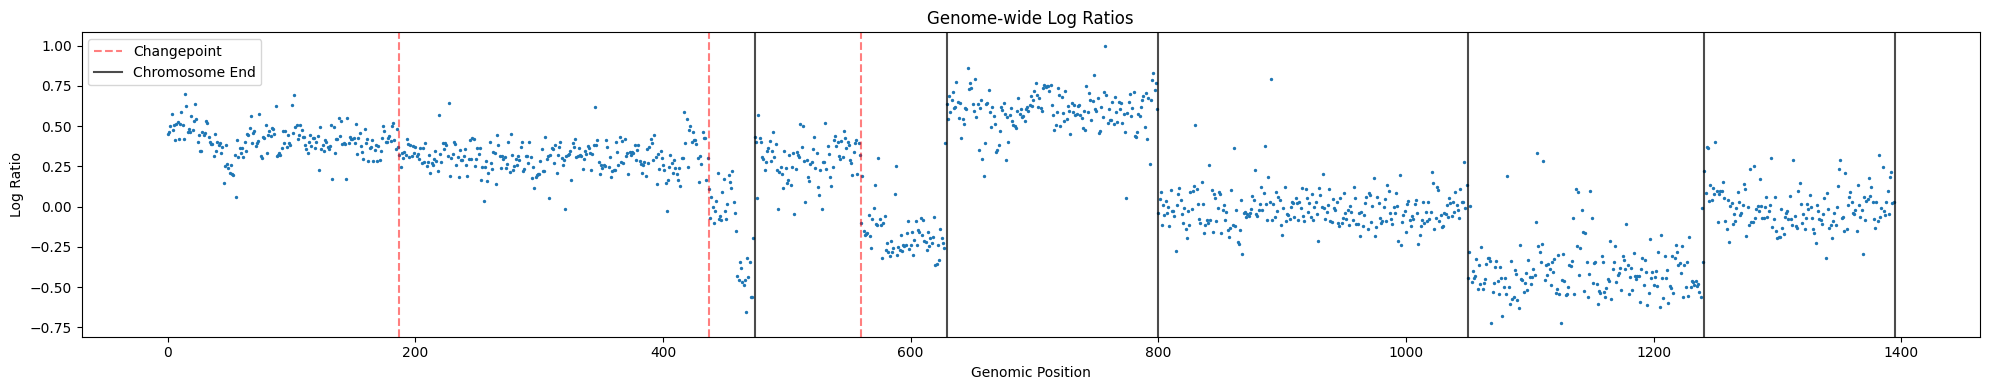

Key: 10
Changepoints: []
Min cost: -43.76687893781205


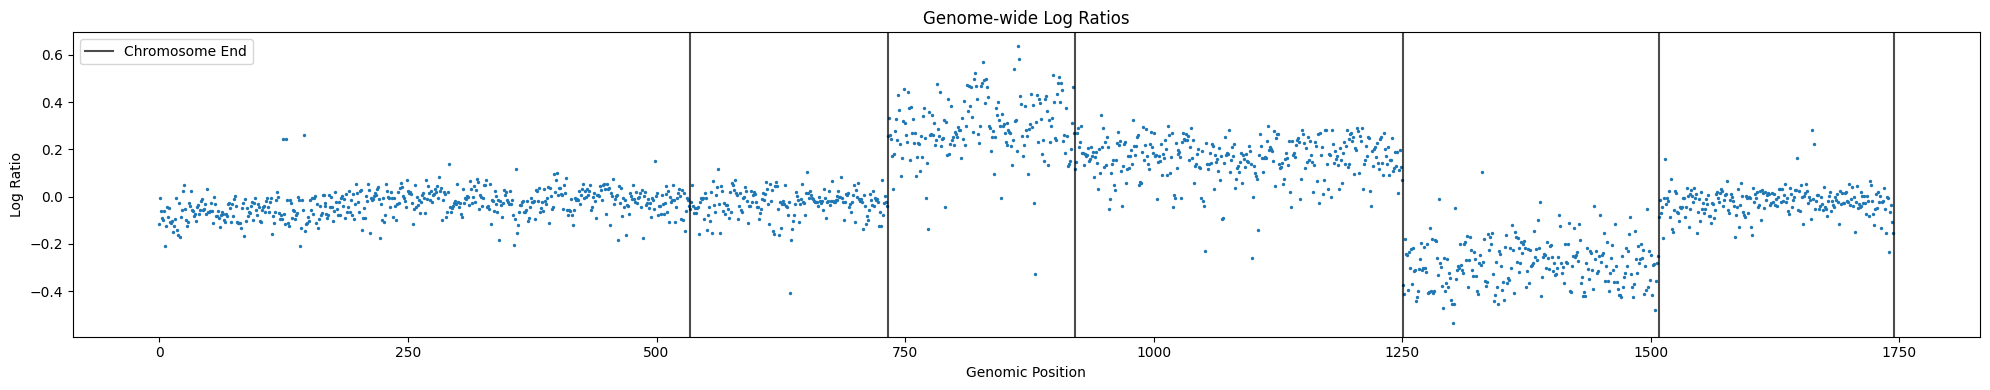

Key: 100
Changepoints: []
Min cost: -4.69120710745279


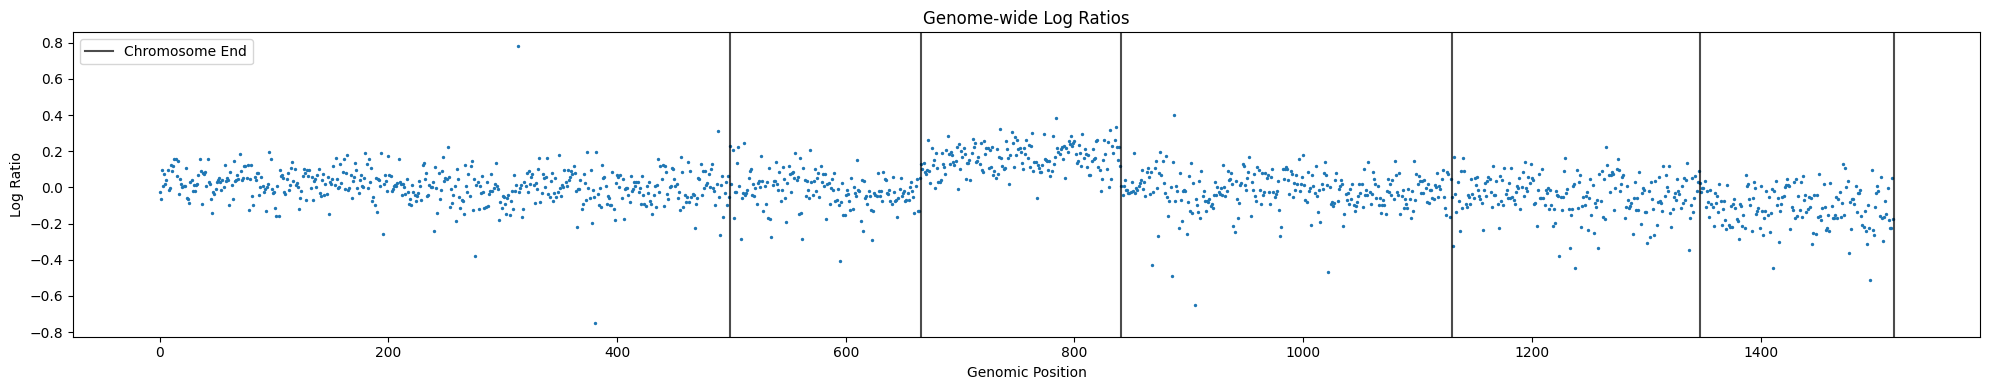

Key: 101
Changepoints: [885]
Min cost: -135.3685225029112


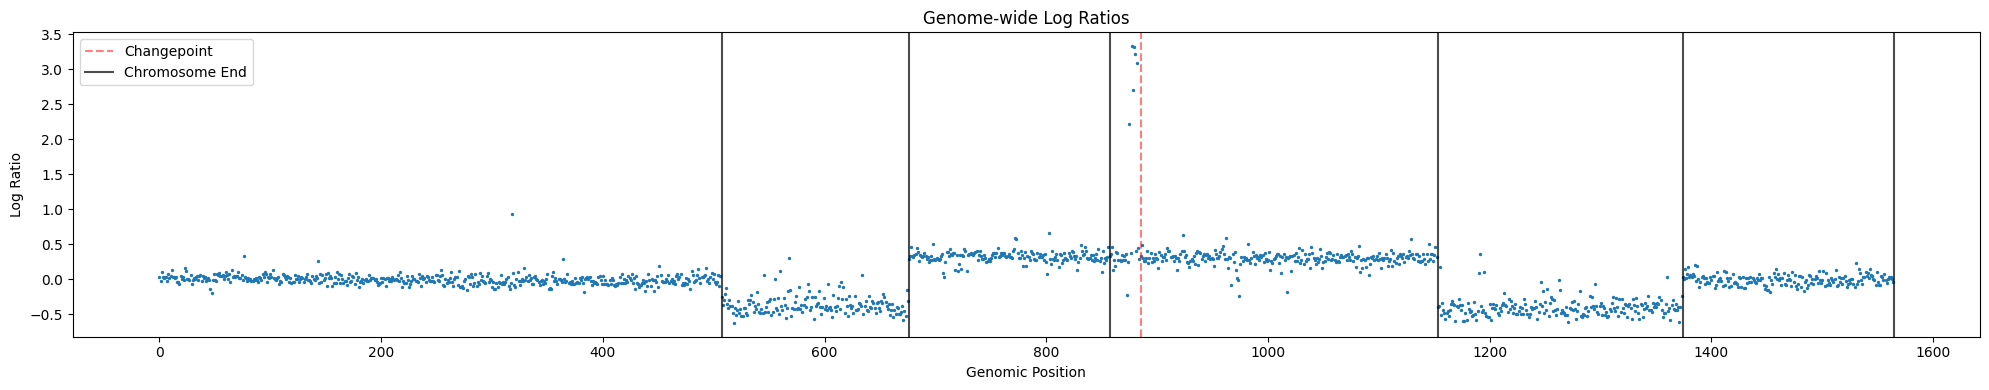

Key: 102
Changepoints: [280 829 914]
Min cost: -143.34839171377976


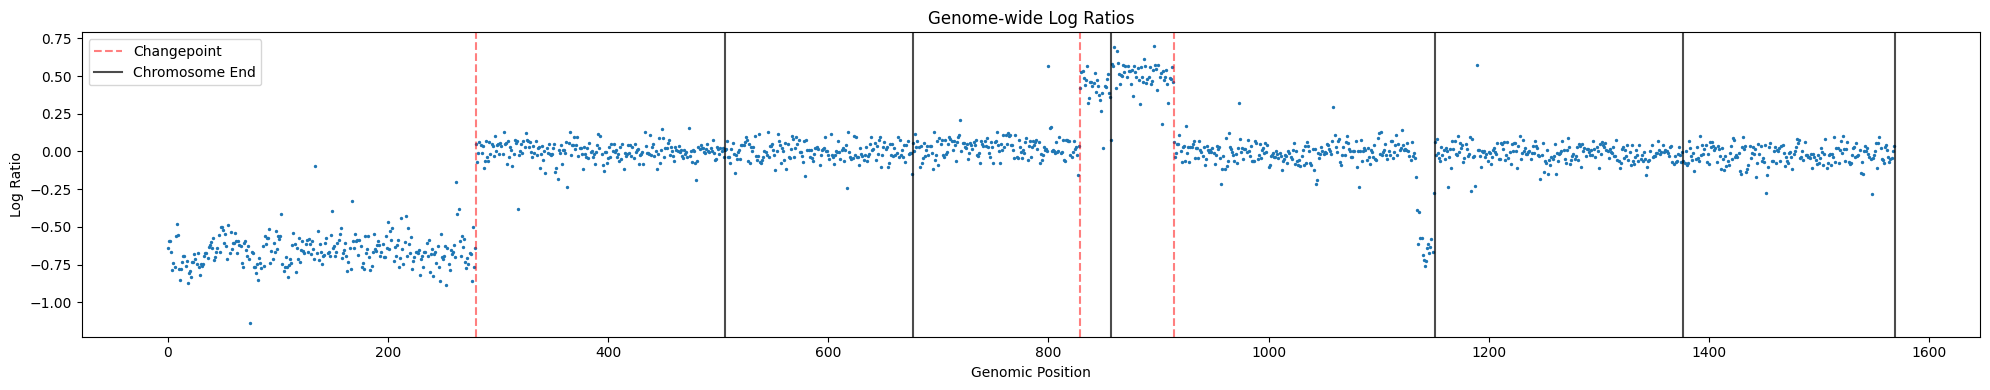

Key: 103
Changepoints: [244 428 741 820]
Min cost: -224.79265653889001


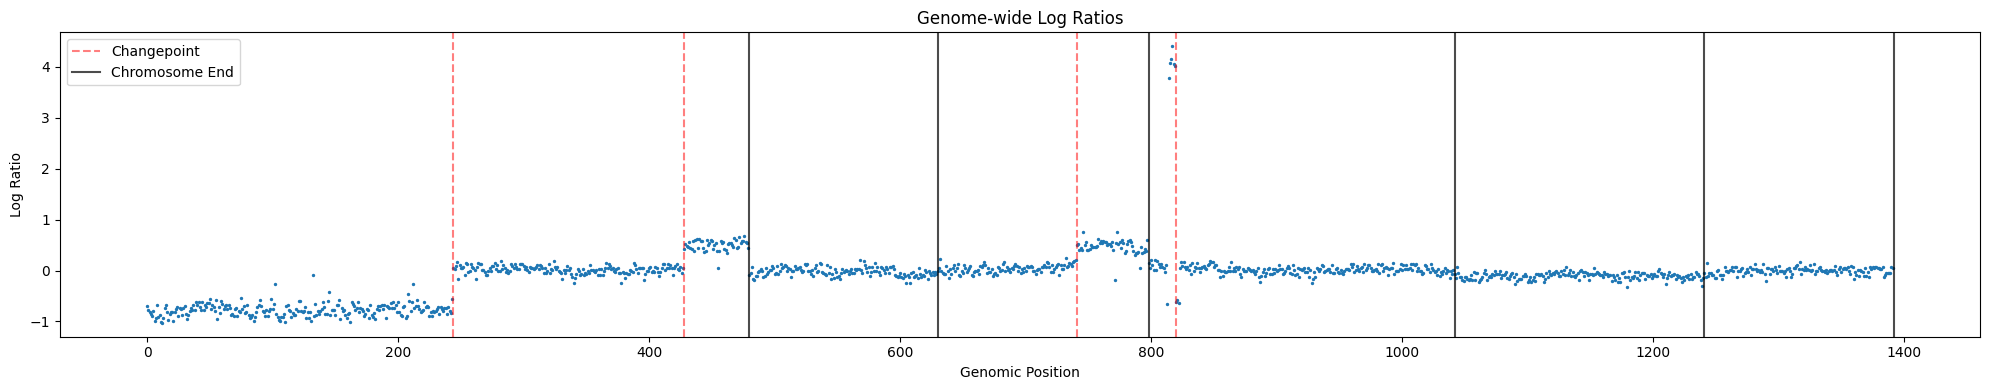

Key: 104
Changepoints: [189 694 718 768 830]
Min cost: -87.87785817059977


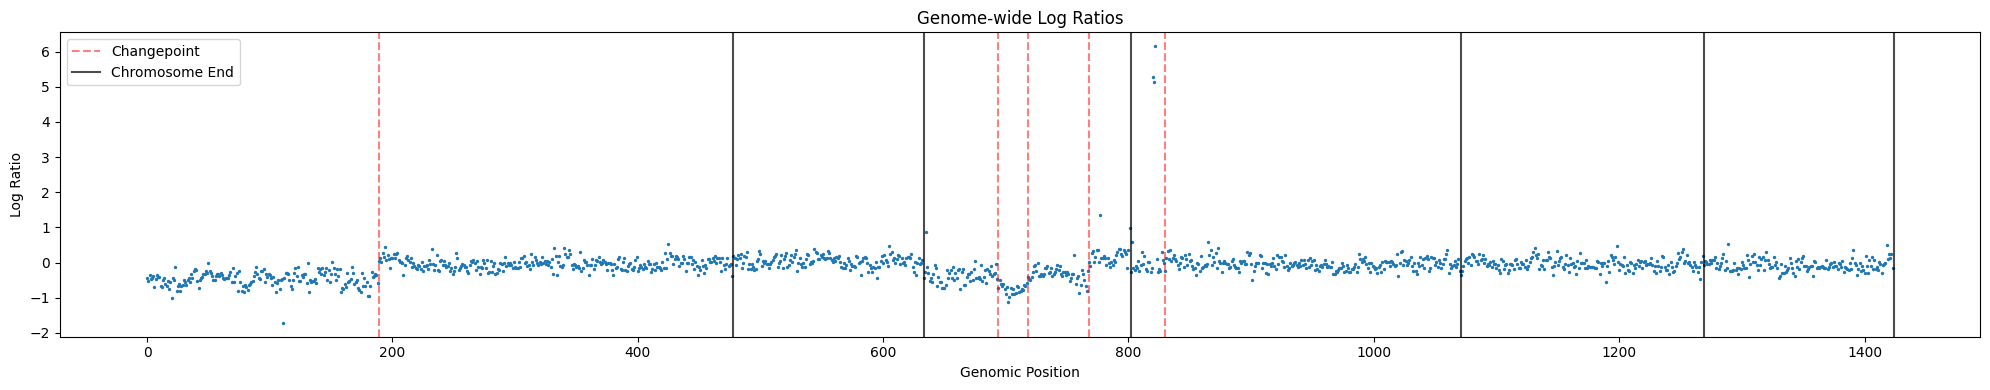

Key: 105
Changepoints: []
Min cost: -5.201358313604933


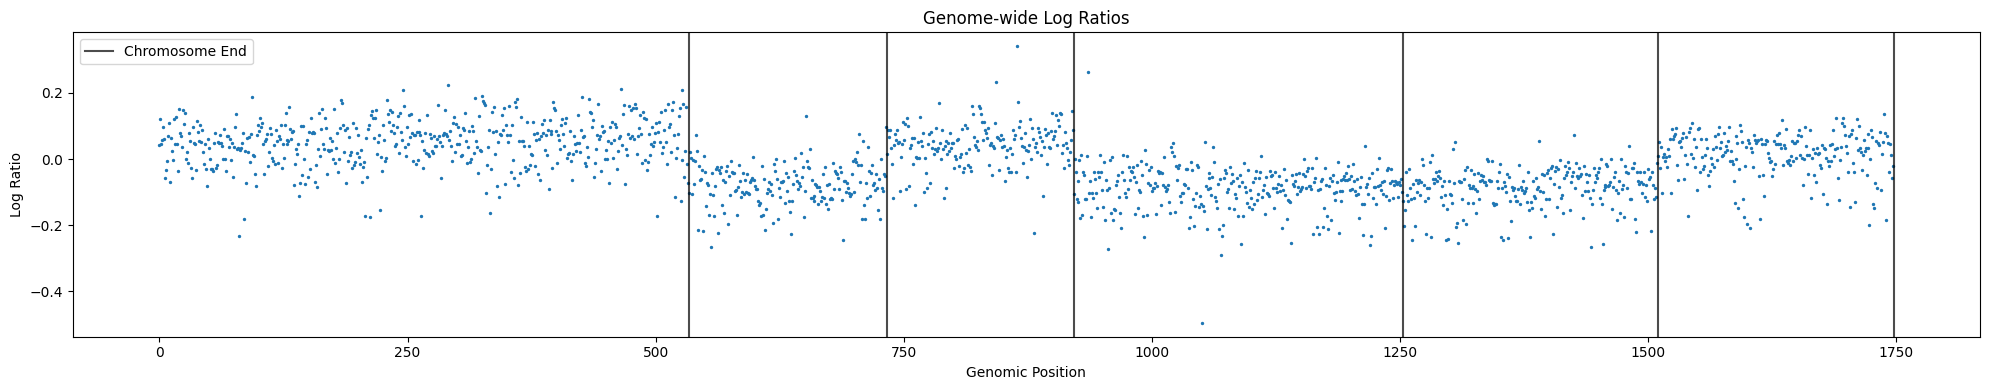

Key: 106
Changepoints: [640 861]
Min cost: -48.081987733822224


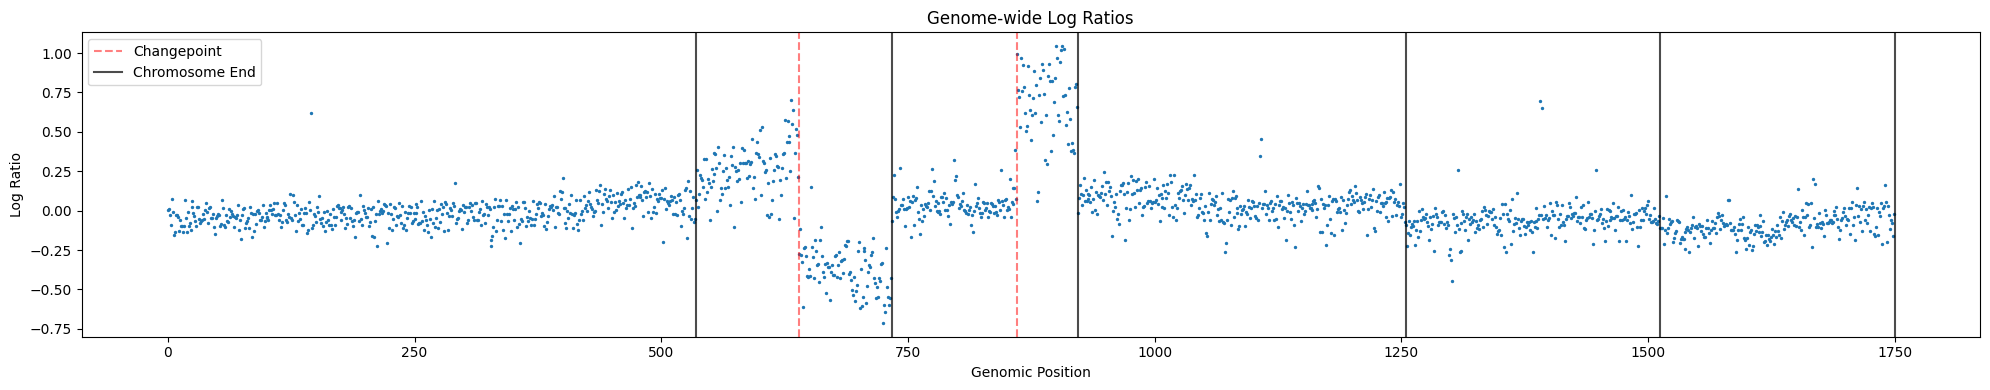

Key: 107
Changepoints: []
Min cost: -36.655427848980636


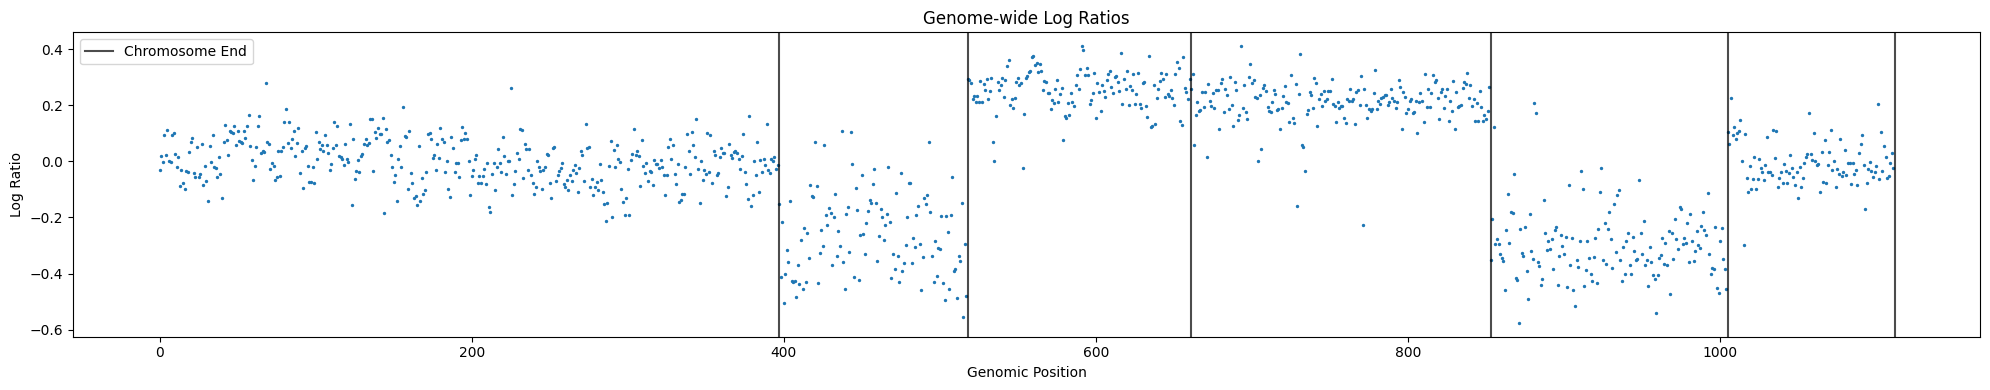

In [ ]:
changepoints_identified_min_seg = {}

for index, (key, chromosome_start_key) in enumerate(zip(list(logratio_dict.keys()), list(chromosome_starts.keys()))):
  data = logratio_dict[str(key)]
  chromosome_start = chromosome_starts[str(chromosome_start_key)]

  sigma = mad_estimate(np.diff(data)/np.sqrt(2))

  op = OptimalPartitioning(
      penalty = 2*sigma*np.log(len(data)),
      cost_func = GaussianCPInMeanCost(),
      min_seg_len = 10
  )
  op.fit(data)

  changepoints = op.get_changepoints()

  # do not consider the changepoint that are due to the start of a new chromosome
  changepoints = filter_changepoints(changepoints, chromosome_start)
  # save the changepoint identified
  changepoints_identified_min_seg[str(key)] = changepoints

  if index < 10:
    print(f"Key: {key}")
    print("Changepoints:", changepoints)
    print("Min cost:", op.get_min_cost())
    plot_genome_logratios(
      data,
      changepoints,
      chromosome_start
      )

In [ ]:
performance = calculate_preformance(
    annotation_dict,
    changepoints_identified_min_seg
)
performance

{'TP': 109, 'FP': 24, 'FN': 1, 'TN': 83}

Calculating the FPR and FNR with a minimum segment length, we observe an improvement in both error rates. 😊

In [ ]:
performance['FP'] / ( performance['FP'] + performance['TP'] )

0.18045112781954886

In [ ]:
performance['FN'] / ( performance['FN'] + performance['TN'] )

0.011904761904761904

## Elbow methods for calibration

Then, we manually applied the elbow method to identify the optimal penalty for change-point detection.

In the context of change-point detection, the algorithm calculates a cost function (e.g., error or variance) for various penalty values. As the penalty decreases, the algorithm identifies more change-points, reducing the cost function. However, at some point, adding more change-points provides diminishing returns.

**The elbow point is the point on the cost vs. penalty plot where the rate of improvement sharply decreases**, forming an “elbow” shape. Choosing the penalty at this point provides a good balance between model complexity (number of change-points) and fit quality (cost function value).

The manual procedure we applied did not allow us to perform the analysis for every profile.

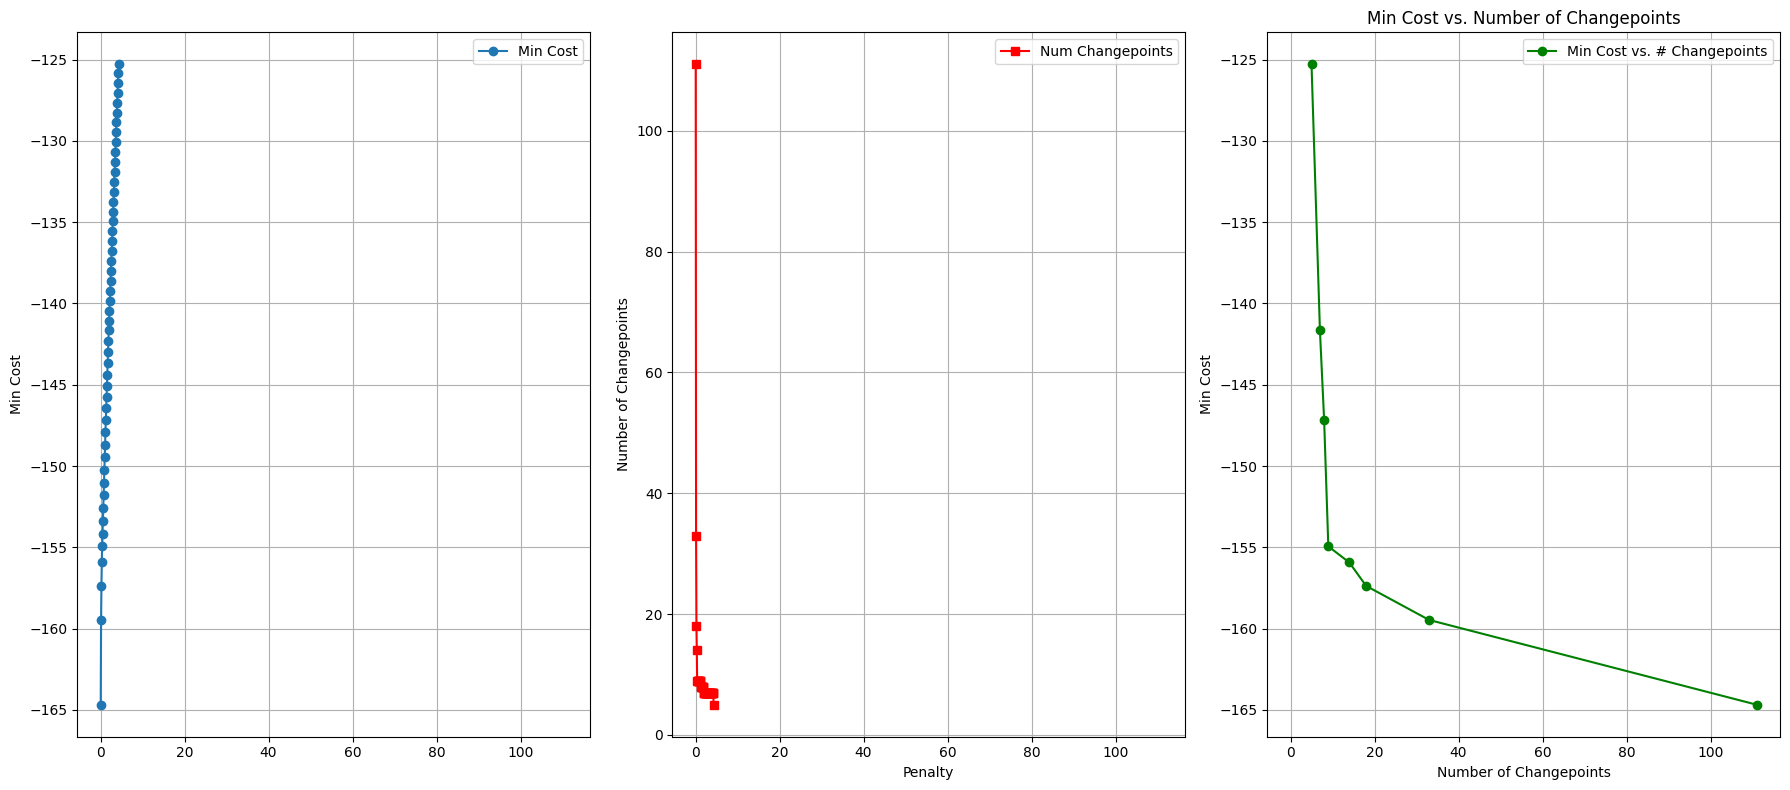

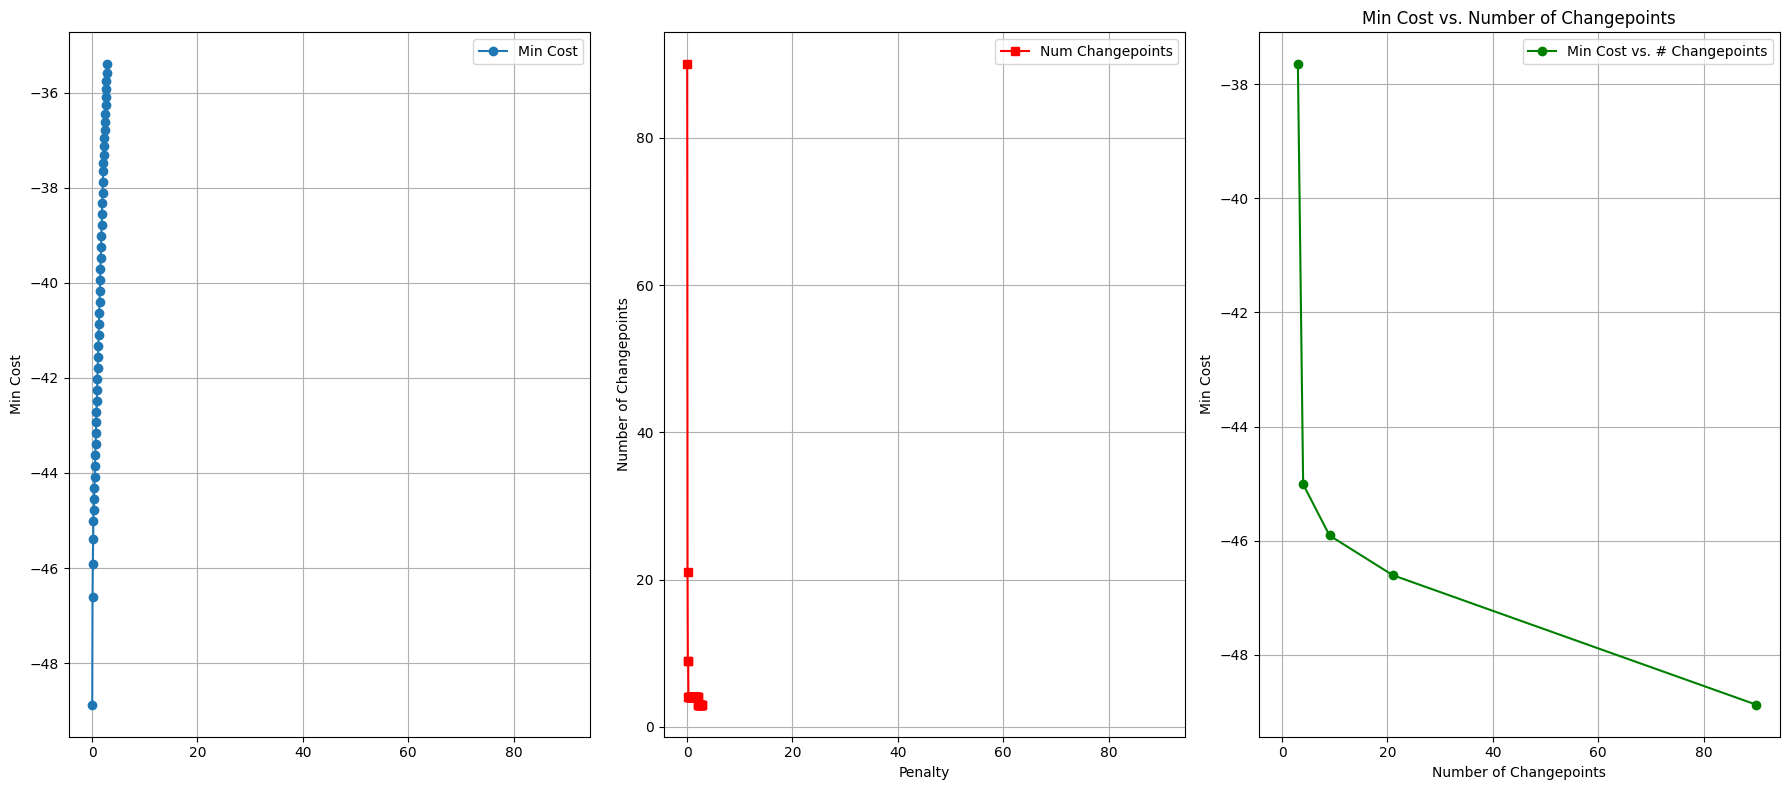

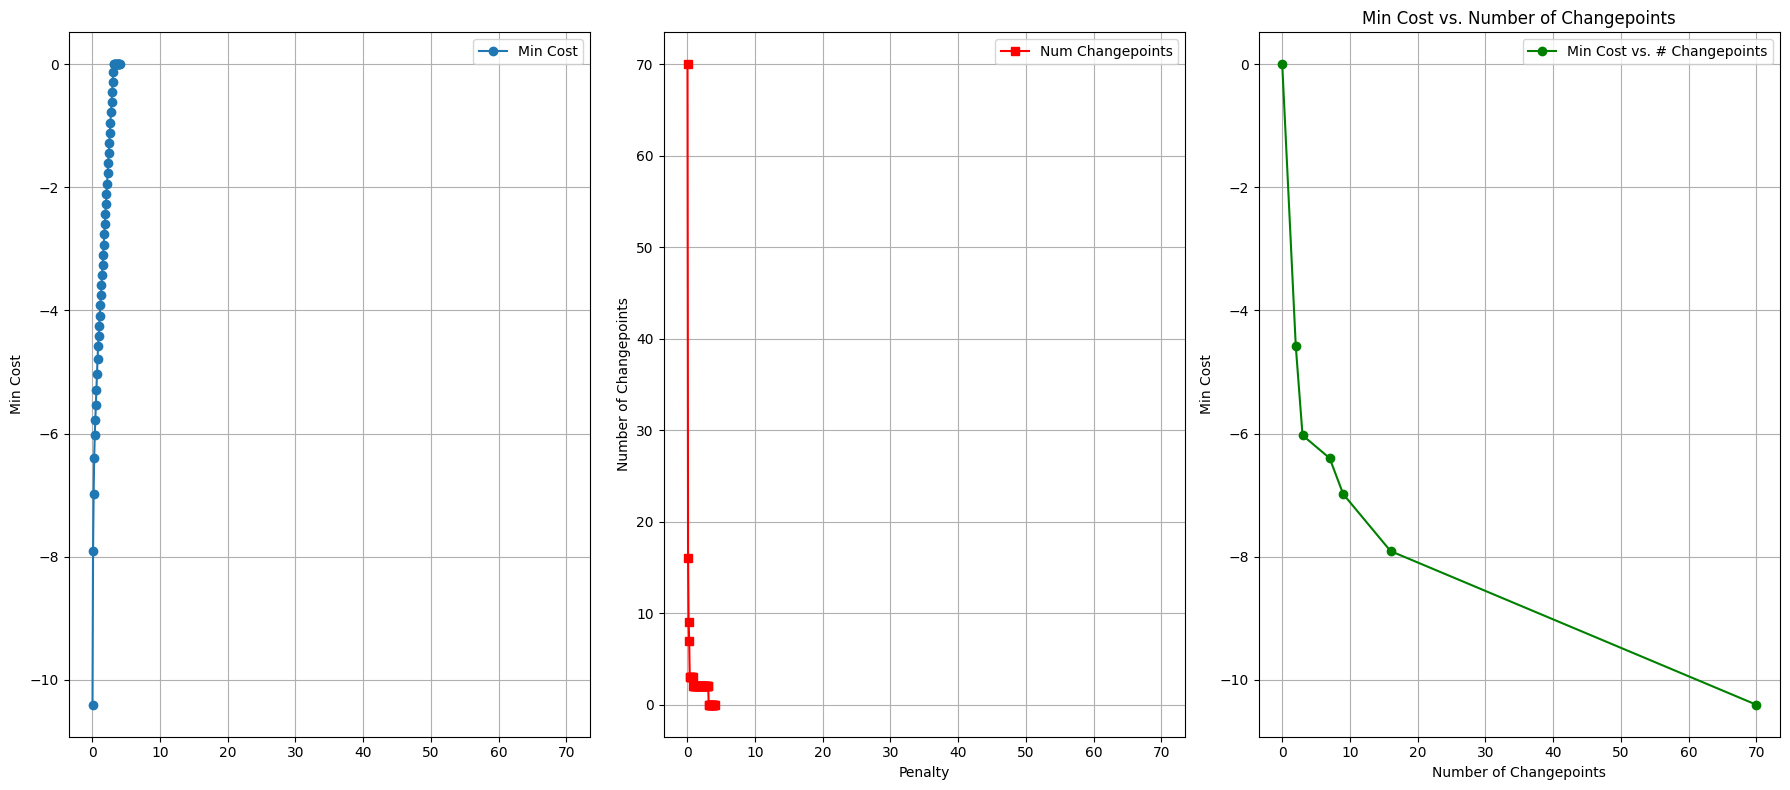

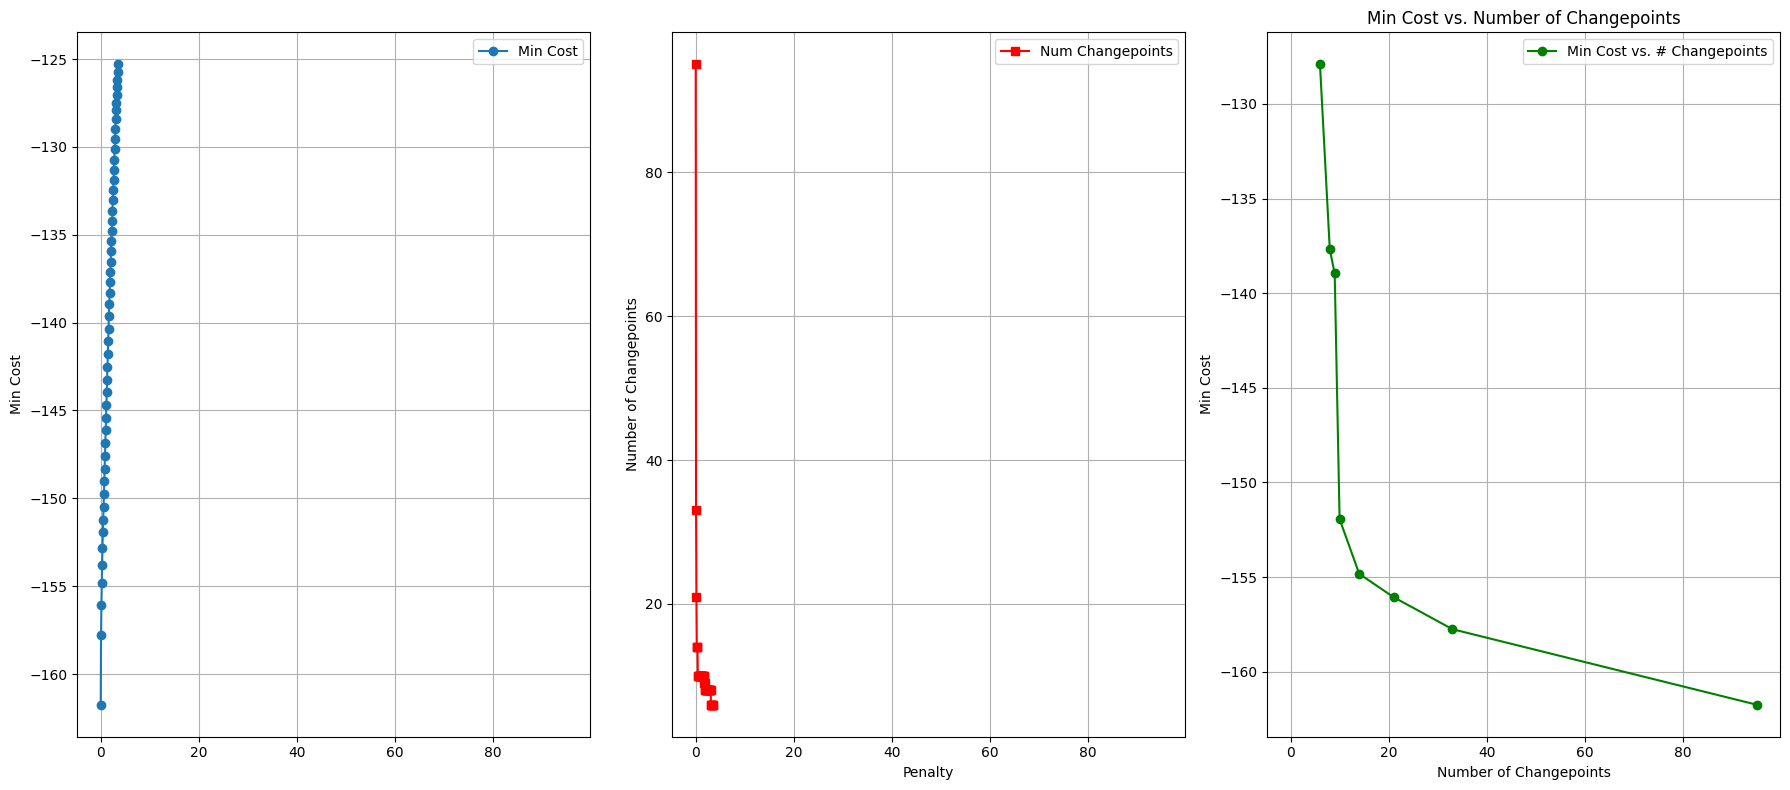

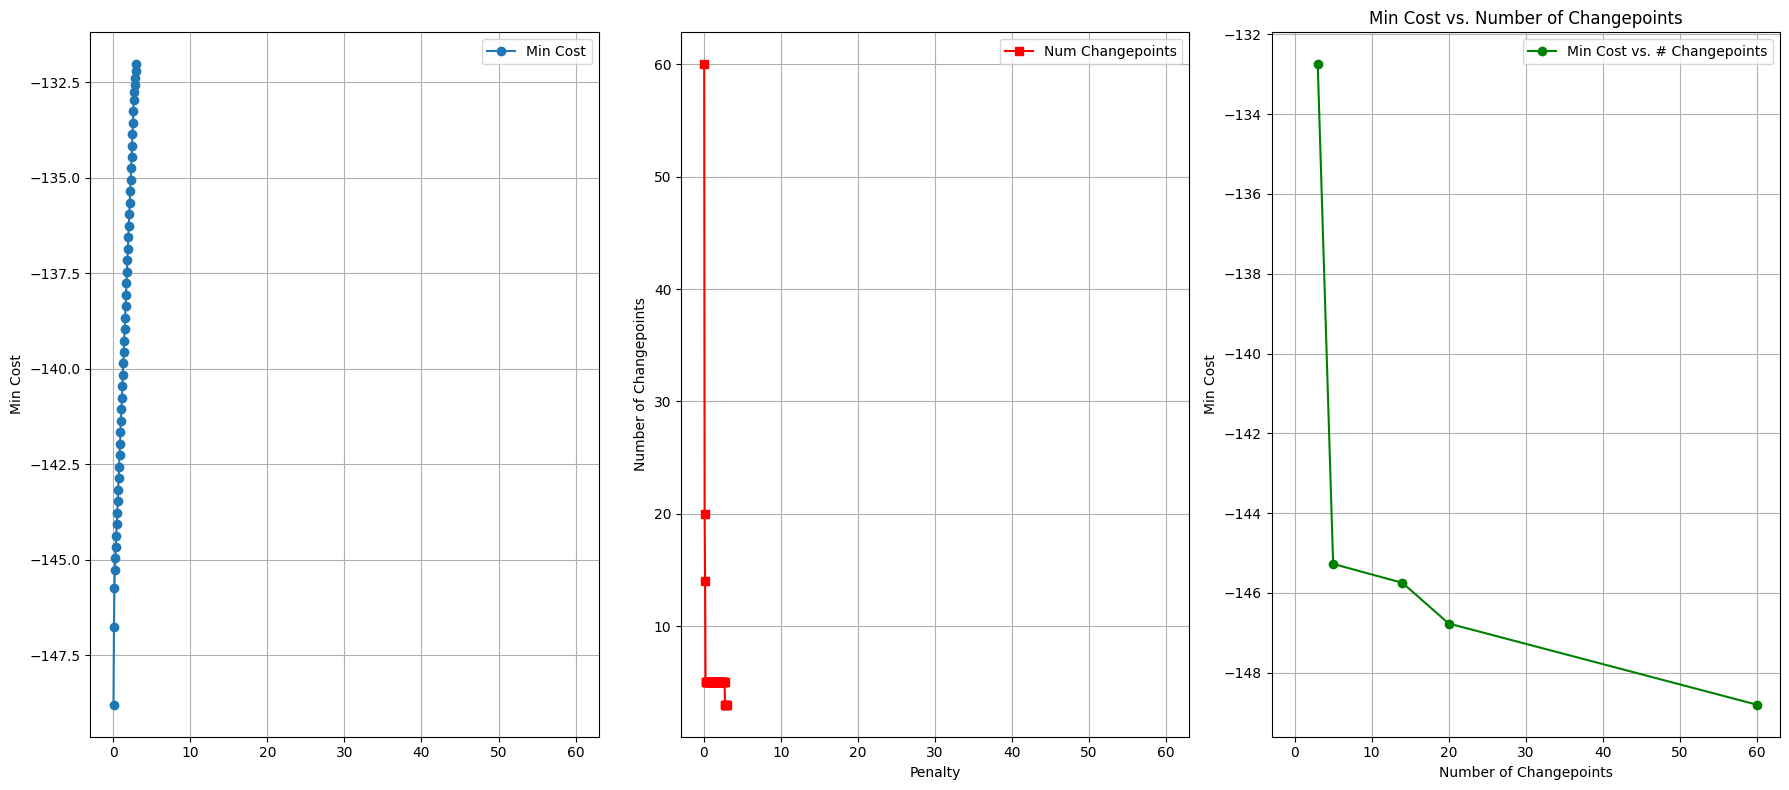

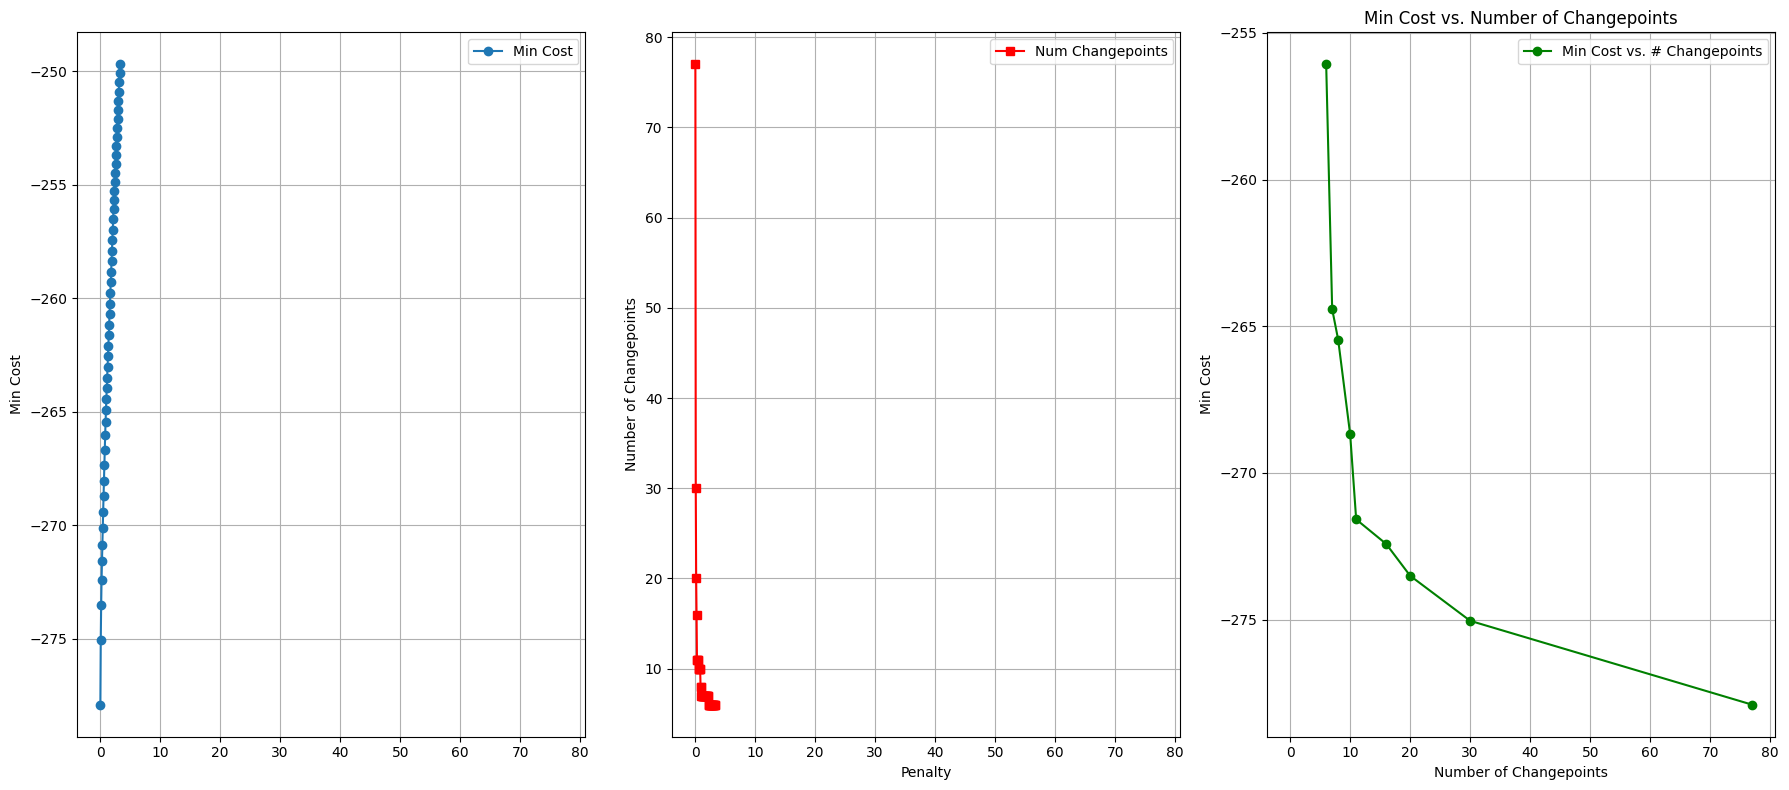

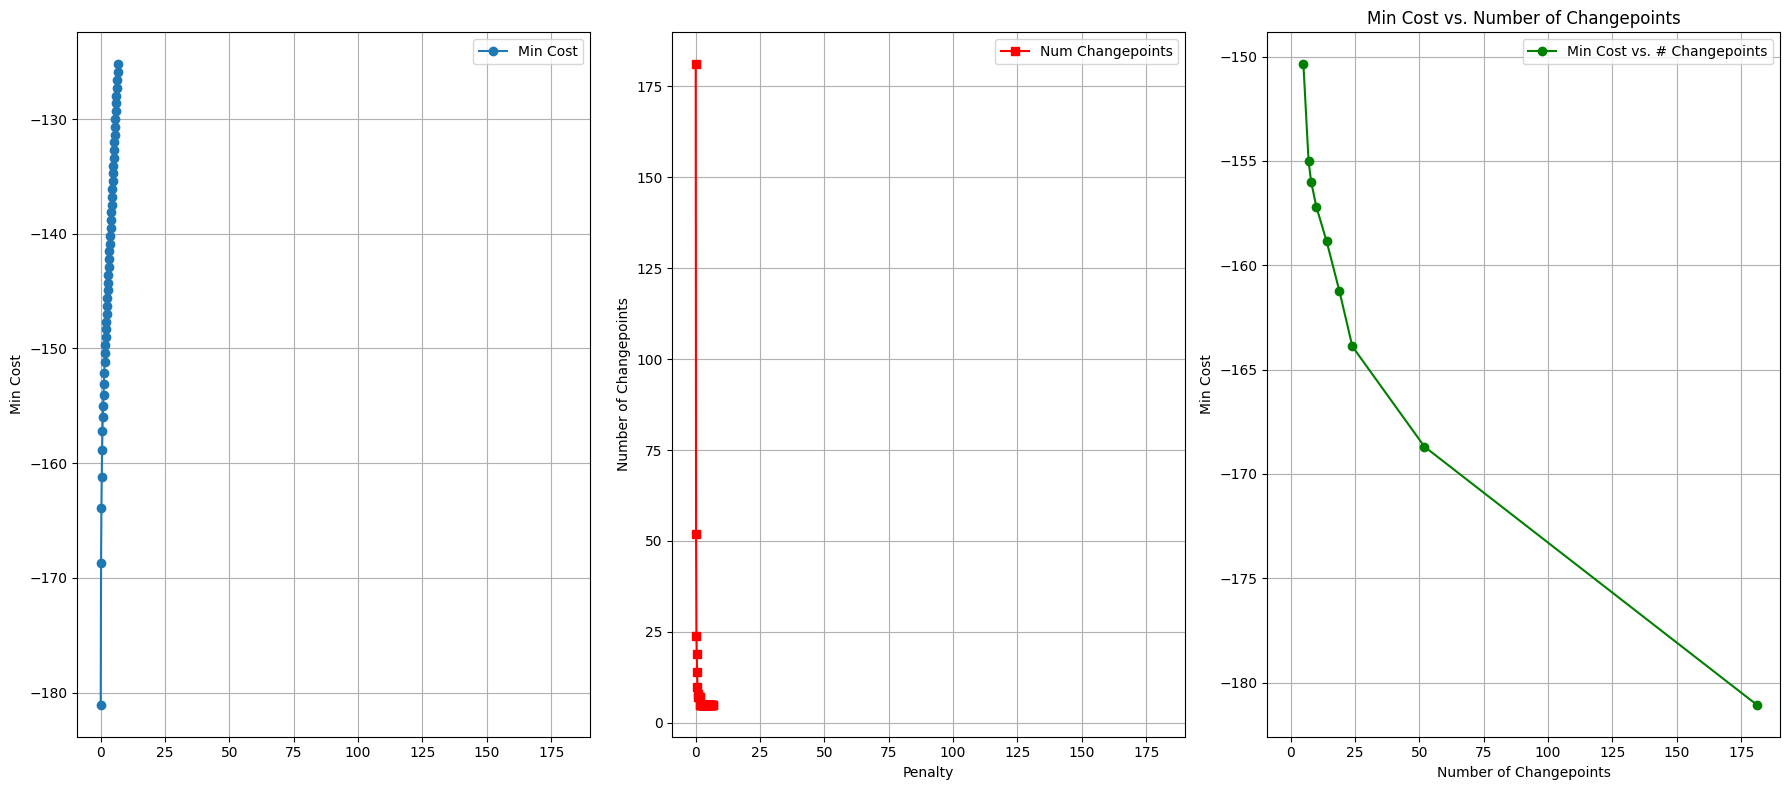

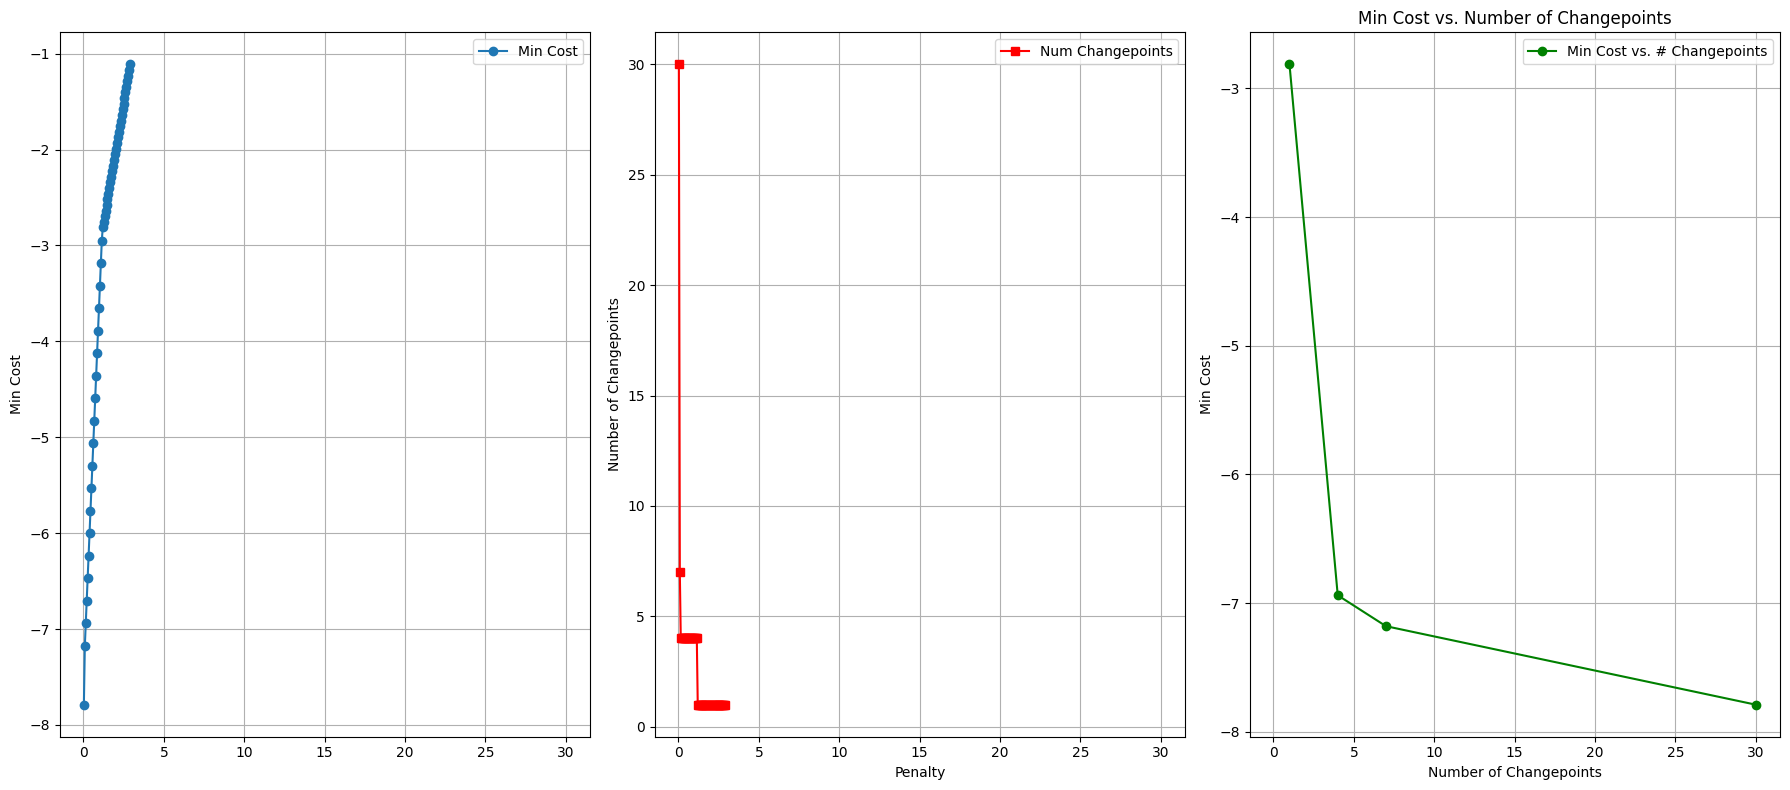

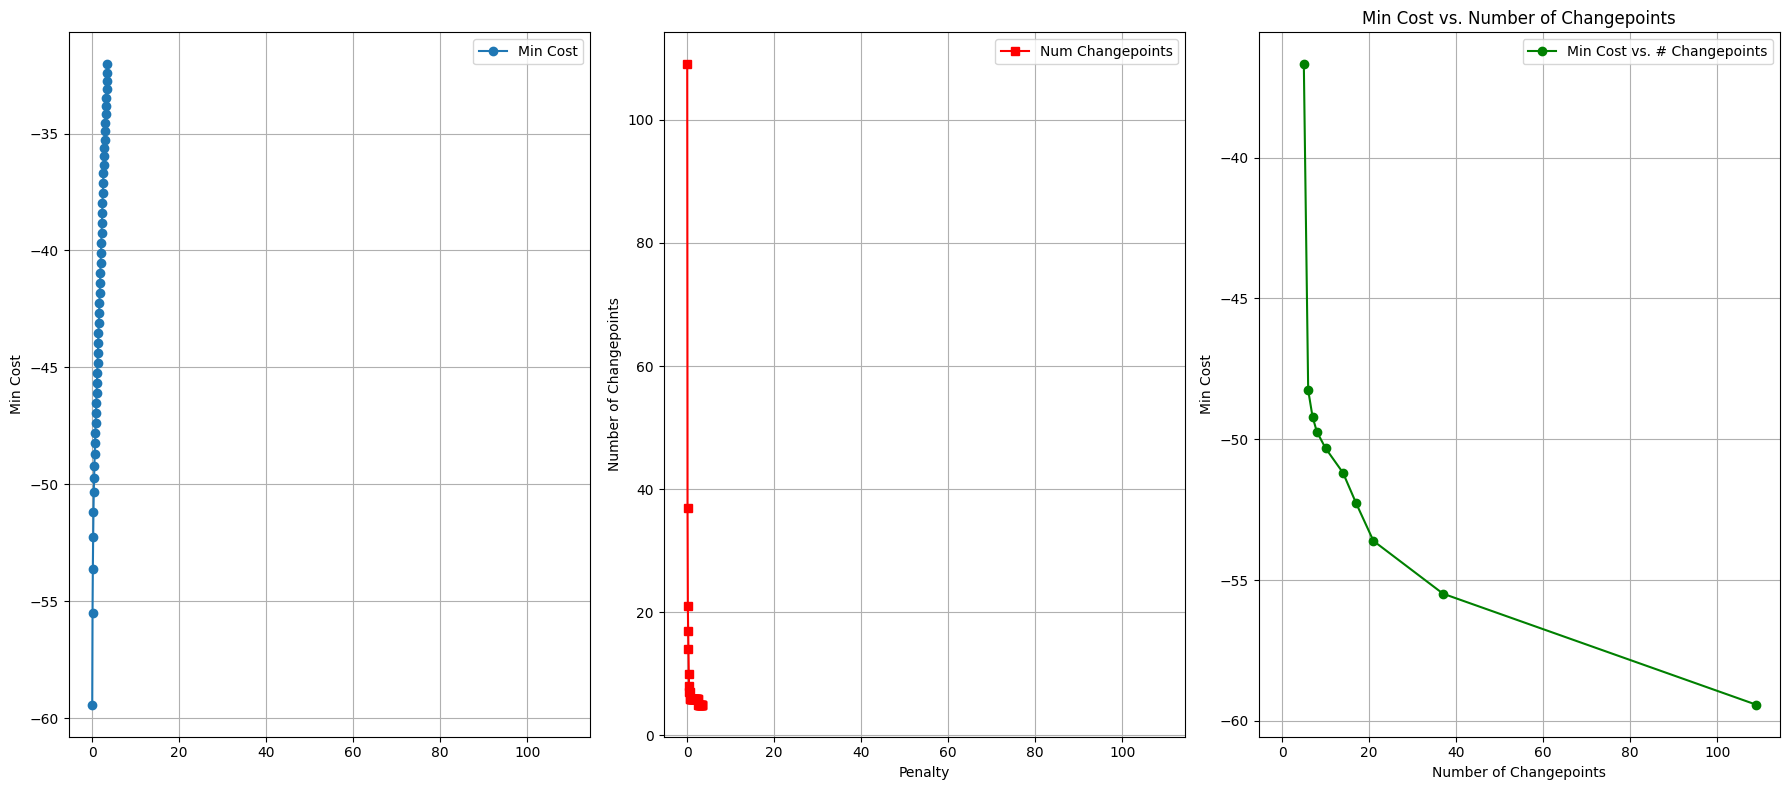

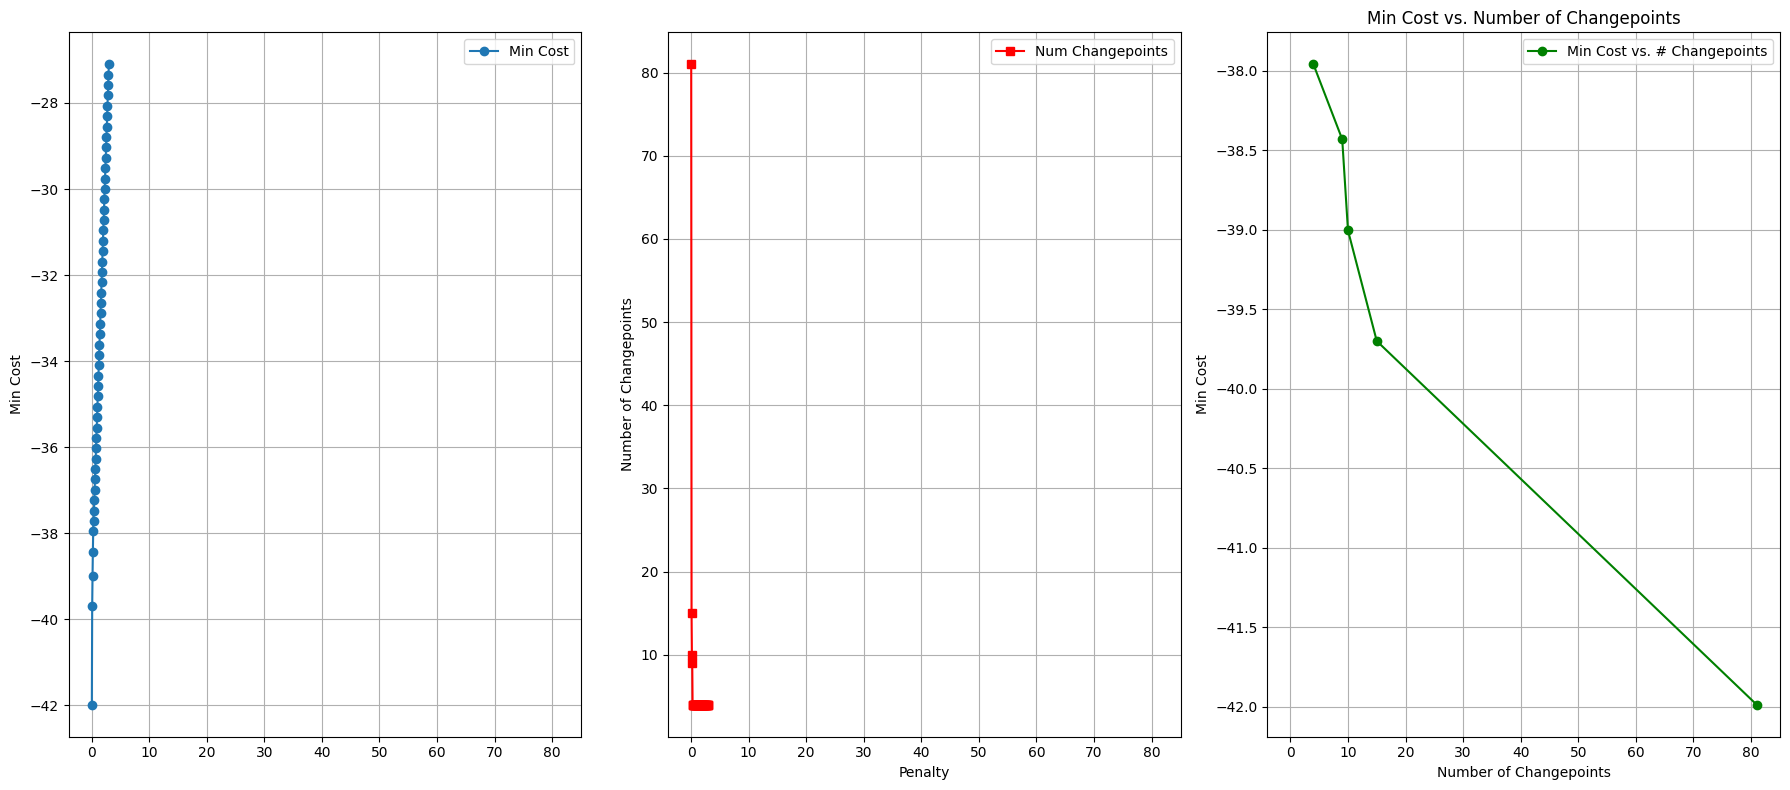

In [ ]:
for key in list(logratio_dict.keys())[:10]:
  data = logratio_dict[str(key)]

  min_costs = []
  num_changepoints = []

  sigma = mad_estimate(np.diff(data)/np.sqrt(2))

  penalties = np.linspace(0.1 * sigma * np.log(len(data)), 10 * sigma * np.log(len(data)), num=50)

  for penalty in penalties:
    op = OptimalPartitioning(
        penalty = penalty,
        cost_func = GaussianCPInMeanCost()
    )
    op.fit(data)

    changepoints = op.get_changepoints()
    num_changepoints.append(len(changepoints))
    min_costs.append(op.get_min_cost())

  # Plot results
  fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)

  # First subplot: Min Costs
  axes[0].plot(penalties, min_costs, marker='o', linestyle='-', label="Min Cost")
  axes[0].set_ylabel("Min Cost")
  axes[0].legend()
  axes[0].grid()

  # Second subplot: Number of Changepoints
  axes[1].plot(penalties, num_changepoints, marker='s', linestyle='-', color='r', label="Num Changepoints")
  axes[1].set_xlabel("Penalty")
  axes[1].set_ylabel("Number of Changepoints")
  axes[1].legend()
  axes[1].grid()

  plt.title(f"Key: {key}")

  min_costs_num = []
  changepoints_num = np.unique(num_changepoints).tolist()
  changepoints_num.sort()

  for num_changepoint in changepoints_num:
      min_costs_num.append(
          min(
              [cost for cost, cp in zip(min_costs, num_changepoints) if cp == num_changepoint]
              )
          )

  # 3. Plot: Min Cost vs. Number of Changepoints
  axes[2].plot(changepoints_num, min_costs_num, marker='o', linestyle='-', color='g', label="Min Cost vs. # Changepoints")
  axes[2].set_xlabel("Number of Changepoints")
  axes[2].set_ylabel("Min Cost")
  axes[2].set_title("Min Cost vs. Number of Changepoints")
  axes[2].legend()
  axes[2].grid(True)

  plt.tight_layout()
  plt.show()

Based on the elbow method we then select the best penalty following these steps:

1.   We pick the best number of changepoints based on the "elbow method" for the right plot ( e.g. , 4 for the last profile)
2.   Based the plot in the middle, we select the corresponding penalty ( e.g. , around 5 for the last profile)

Sometime, for example with the third profile, it is not trivial to graphically
identify the desired loss.

Key: 1
Changepoints: [437 560]
Min cost: -145.24864812959072


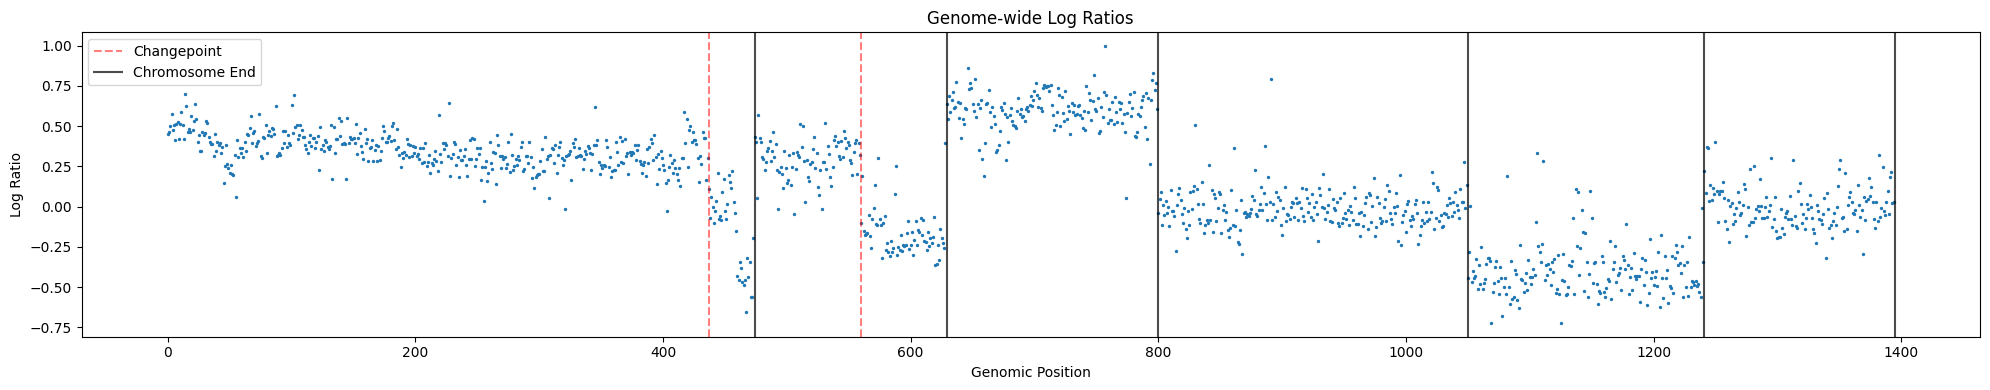

Key: 10
Changepoints: []
Min cost: -42.04706372344789


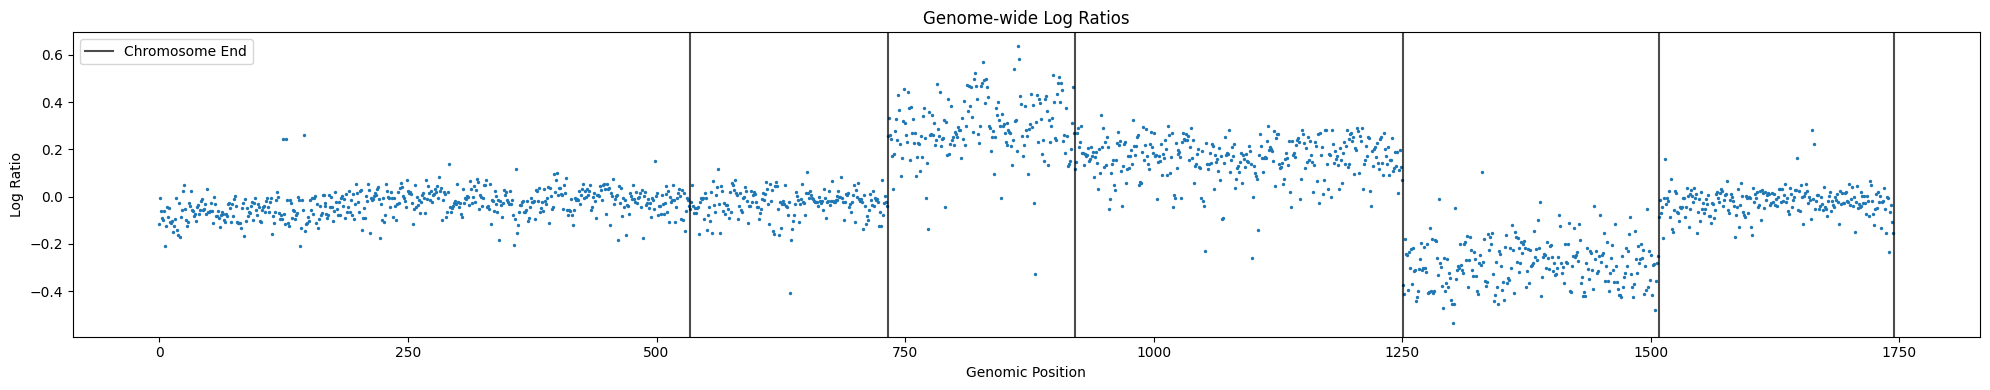

Key: 100
Changepoints: [ 254  313  314  381  382  595  596  885  886  888  905  906 1022 1023
 1215 1265 1281]
Min cost: -8.333872798661215


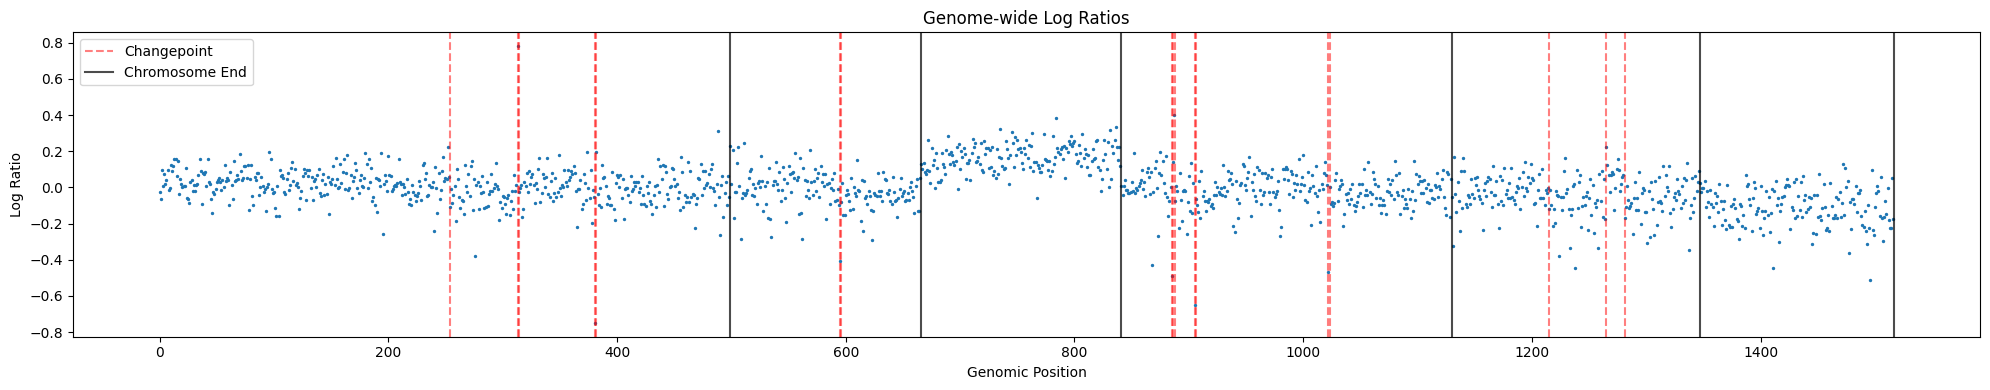

Key: 101
Changepoints: [881 882 883]
Min cost: -146.6481464817954


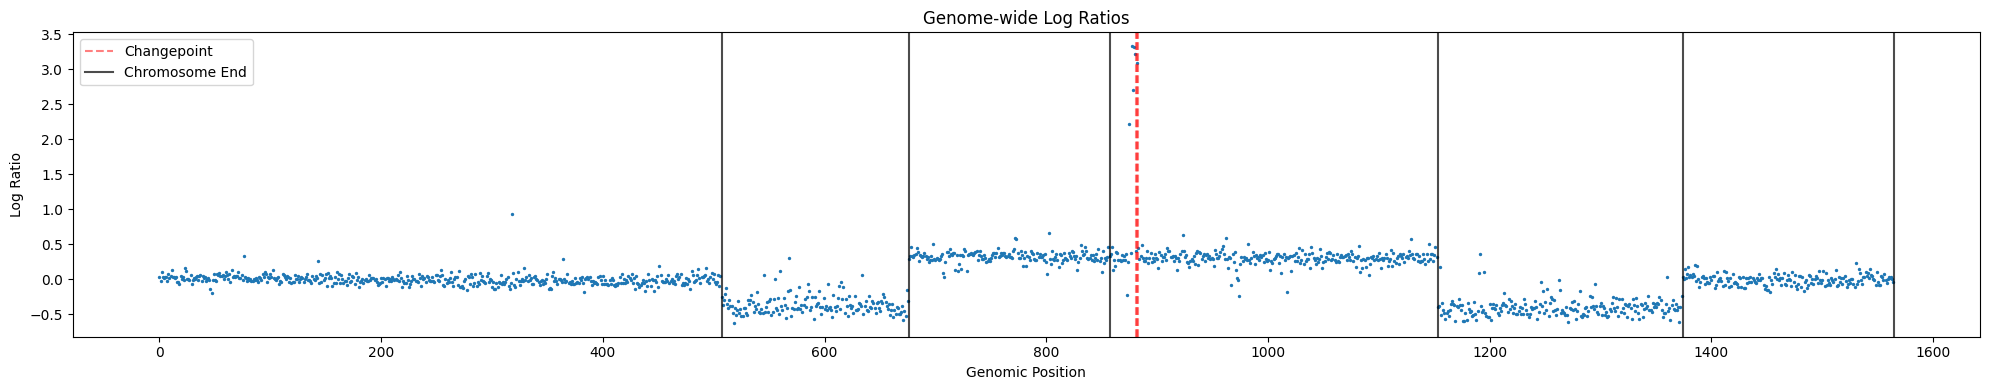

Key: 102
Changepoints: [280 829 914]
Min cost: -141.3212087256144


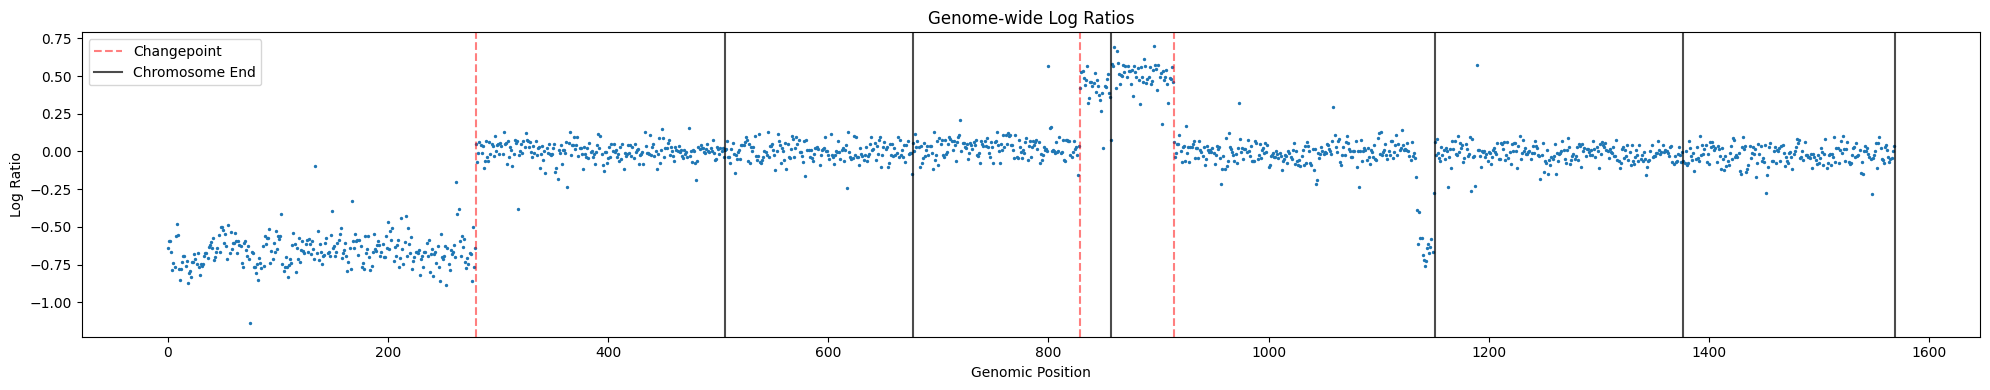

Key: 103
Changepoints: [244 428 741 820 823]
Min cost: -269.3687237928917


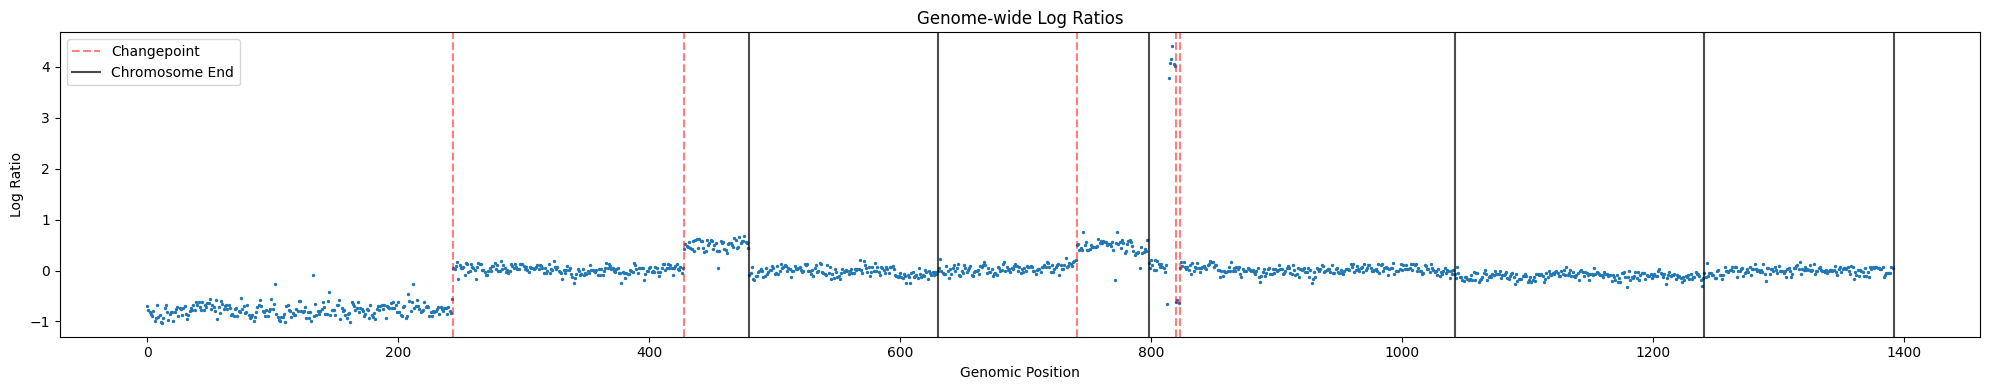

Key: 104
Changepoints: [189 768 823]
Min cost: -148.86519699886378


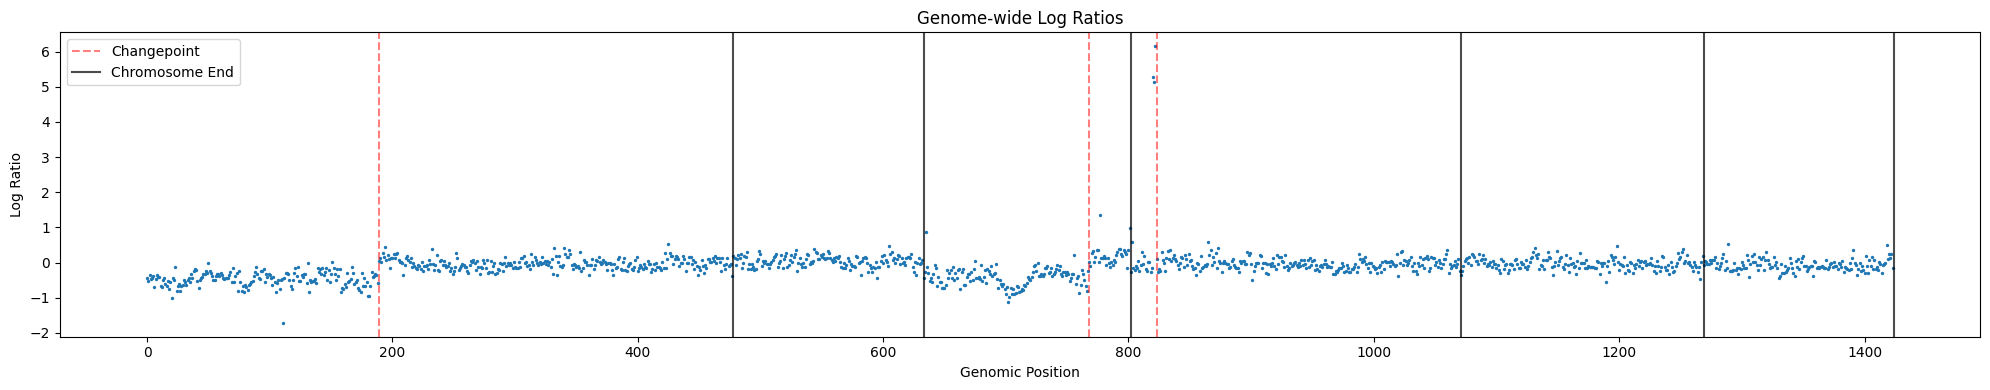

Key: 105
Changepoints: []
Min cost: -5.524303172952939


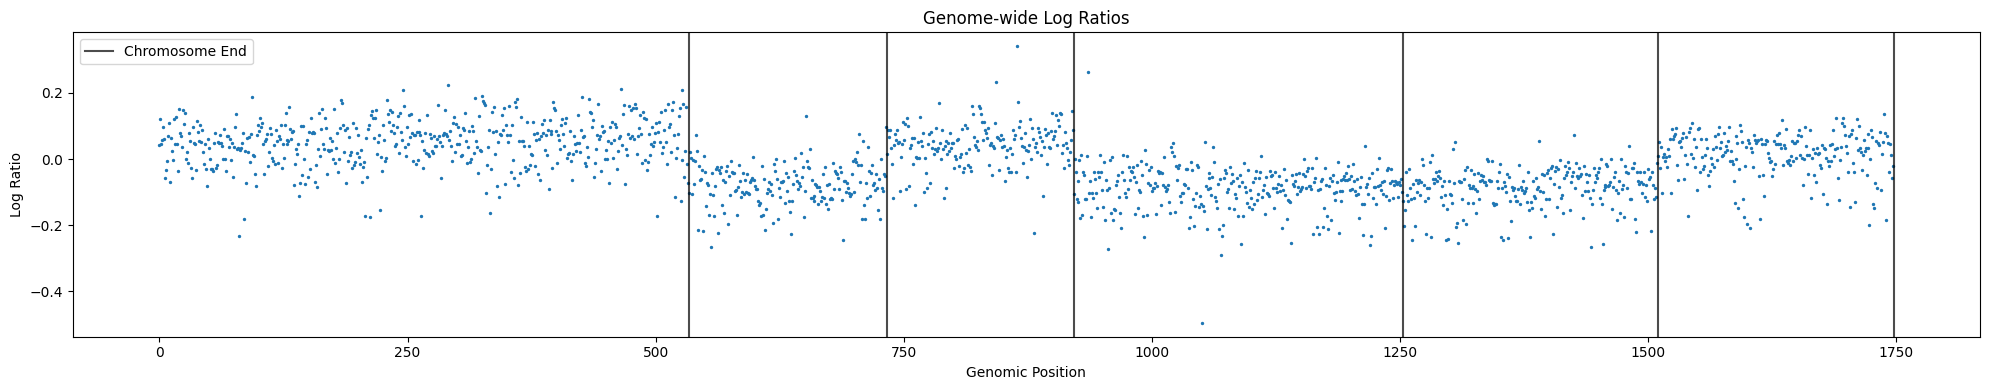

Key: 106
Changepoints: [640 861]
Min cost: -40.327291623941335


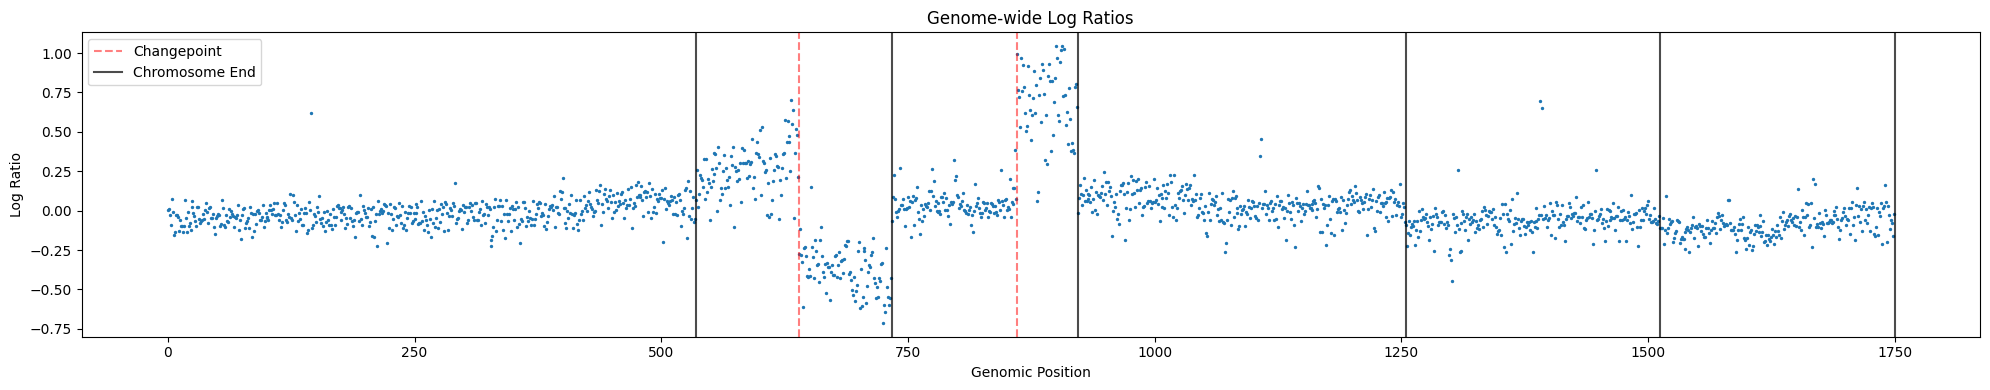

Key: 107
Changepoints: []
Min cost: -19.043715166616515


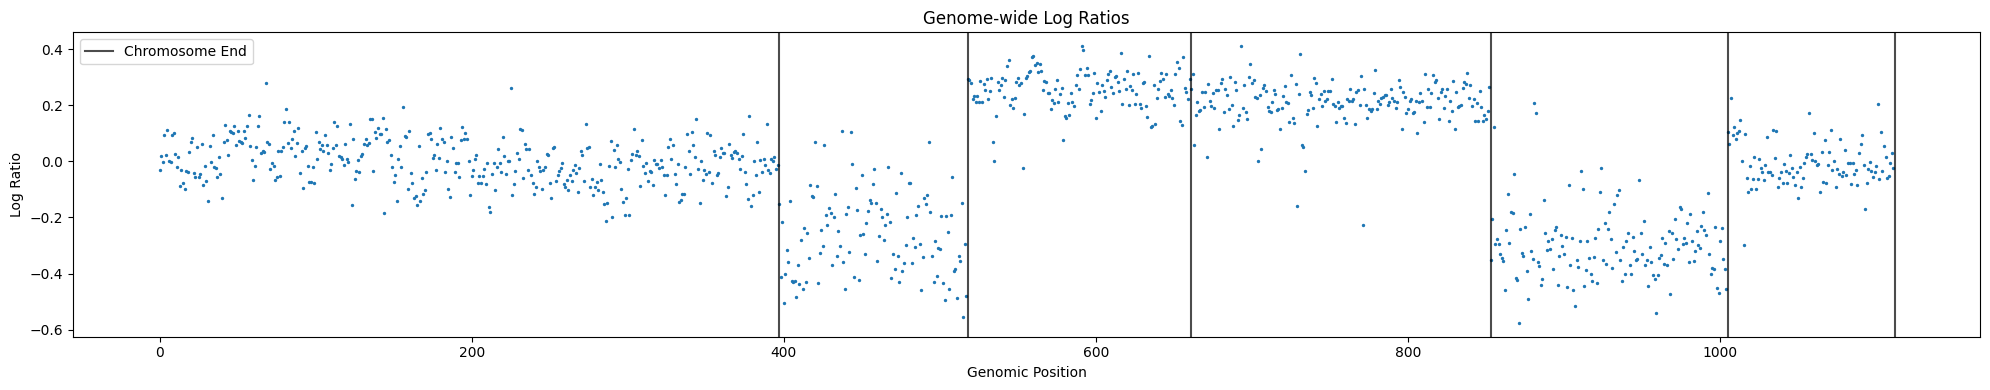

In [29]:
# The penalty selected with the elbow methods
penalties_elbow = [ 1.5, 1., 0.1, 1., 1., 0.5, 2., 0.5, 2., 5.]

for key, penalty in zip(list(logratio_dict.keys())[:10], penalties_elbow):
  data = logratio_dict[str(key)]
  chromosome_start = chromosome_starts[str(key)]

  op = OptimalPartitioning(
      penalty = penalty,
      cost_func = GaussianCPInMeanCost()
  )
  op.fit(data)

  changepoints = op.get_changepoints()

  # do not consider the changepoint that are due to the start of a new chromosome
  changepoints = filter_changepoints(changepoints, chromosome_start)
  # save the changepoint identified
  changepoints_identified_min_seg[str(key)] = changepoints
  print(f"Key: {key}")
  print("Changepoints:", changepoints)
  print("Min cost:", op.get_min_cost())

  plot_genome_logratios(
      data,
      changepoints,
      chromosome_start
      )